In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.sparse

Building initial network...
Running network degradation simulation...


  3%|▎         | 11/400 [01:16<45:51,  7.07s/it]

Saved snapshot: snapshot_t0010.npz


 25%|██▌       | 101/400 [10:22<24:31,  4.92s/it]

Saved snapshot: snapshot_t0100.npz


 38%|███▊      | 151/400 [13:07<08:08,  1.96s/it]

Saved snapshot: snapshot_t0150.npz


 50%|█████     | 201/400 [17:24<25:34,  7.71s/it]

Saved snapshot: snapshot_t0200.npz


 65%|██████▌   | 261/400 [21:14<03:12,  1.38s/it]

Saved snapshot: snapshot_t0260.npz


 69%|██████▉   | 276/400 [21:29<01:50,  1.12it/s]

Saved snapshot: snapshot_t0275.npz


 75%|███████▌  | 301/400 [21:46<00:55,  1.77it/s]

Saved snapshot: snapshot_t0300.npz


 88%|████████▊ | 351/400 [22:10<00:22,  2.22it/s]

Saved snapshot: snapshot_t0350.npz


100%|██████████| 400/400 [22:33<00:00,  3.38s/it]


Plotting network degradation...


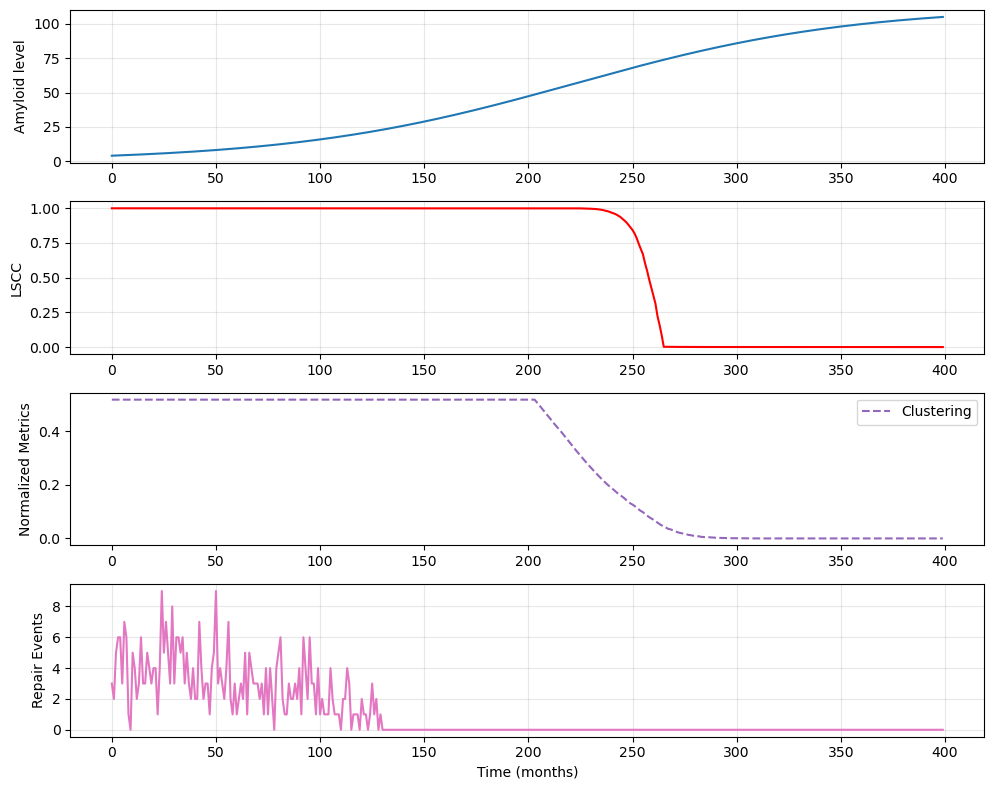

Simulation complete. Metrics saved to 'simulation_metrics.npz'
Snapshot adjacency matrices saved for times: [10, 100, 150, 200, 260, 275, 300, 350, 400]


In [4]:
# ==============================
# ========== PARAMETERS ==========
# ==============================

N = 10000
k = 20
p_rewire = 0.1

# Time parameters
t_max = 400
dt = 1
time_steps = int(t_max / dt)

# Amyloid dynamics
A_max = 150
k_A = 0.02
beta = 0.001
A_th = 25
clearance_rate = 0.005

# Repair mechanisms
base_repair_rate = 0.02
repair_strength = 0.03

# Synaptic decay
W_0 = 1.0
W_min = W_0 * (1 / (2 * np.e))
tau_synapse = 120

# Snapshot points (in real time units, i.e., months)
snapshot_times = [10, 100, 150, 200, 260, 275, 300, 350, 400]

# Storage arrays
te = []
repair_events = []
lscc_time = []
ge_time = []
amyloid_time = []
clust_time = []

# ==============================
# ========== FUNCTIONS ==========
# ==============================

def repair_network(G, W_0, p_repair, repair_strength):
    """Attempt repair on synapses and add new connections"""
    n_repairs = 0

    # Repair existing synapses
    for u, v, data in list(G.edges(data=True)):
        if np.random.rand() < p_repair:
            G[u][v]['weight'] = min(W_0, G[u][v]['weight'] * (1 + repair_strength))
            n_repairs += 1

    # Add new connections
    if np.random.rand() < p_repair / 2:
        nodes = list(G.nodes())
        if len(nodes) >= 2:
            u, v = np.random.choice(nodes, 2, replace=False)
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=W_0 * 0.5)
                n_repairs += 1

    return G, n_repairs

def compute_lscc(G, N):
    """Compute the Largest Strongly Connected Component as a fraction of the original network size"""
    if G.number_of_edges() == 0:
        return 0
    components = list(nx.strongly_connected_components(G))
    if not components:
        return 0
    max_size = max(len(c) for c in components)
    return max_size / N

def global_efficiency(G, N):
    """
    Compute the global efficiency of the graph G.  Handles disconnected graphs.
    """
    if G.number_of_nodes() <= 1:
        return 0
    path_lengths = dict(nx.all_pairs_shortest_path_length(G))
    n = G.number_of_nodes()
    eff_sum = 0.0
    for source, targets in path_lengths.items():
        for target, length in targets.items():
            if source != target and length > 0:
                eff_sum += 1.0 / length
    return eff_sum / (n * (n - 1)) if n > 1 else 0

# ==============================
# ========== INITIALIZATION ==========
# ==============================

np.random.seed(42)
original_N = N

print("Building initial network...")
G = nx.watts_strogatz_graph(N, k, p_rewire)
G = nx.DiGraph(G)

# Create directed edges
for u, v in list(G.edges()):
    G.remove_edge(u, v)
    if np.random.rand() < 0.5:
        G.add_edge(u, v, weight=W_0)
    else:
        G.add_edge(v, u, weight=W_0)

# Initial amyloid
A = 4

print("Running network degradation simulation...")

# ==============================
# ========== SIMULATION LOOP ==========
# ==============================

for t in tqdm(range(time_steps)):
    current_time = t * dt

    # Amyloid accumulation
    A += dt * (k_A * A * (1 - A / A_max))
    A -= dt * clearance_rate * A
    A = max(0, A)
    amyloid_time.append(A)

    # Synaptic weakening probability
    p_t = 1 - np.exp(-beta * (A - A_th)) if A > A_th else 0

    # Synaptic decay and pruning
    edges_to_remove = []
    for u, v, data in G.edges(data=True):
        if np.random.rand() < p_t:
            # Apply exponential decay based on absolute time
            data['weight'] = W_0 * np.exp(-current_time / tau_synapse)
        if data['weight'] < W_min:
            edges_to_remove.append((u, v))
    G.remove_edges_from(edges_to_remove)

    # Network Repair Mechanisms
    current_repair_rate = base_repair_rate * (1 - np.exp(-0.01 * (A_th - A))) / np.sqrt(original_N)
    current_repair_rate = max(0, current_repair_rate)  # Ensure non-negative
    G, n_repairs = repair_network(G, W_0, current_repair_rate, repair_strength)
    repair_events.append(n_repairs)

    # Calculate metrics
    lscc = compute_lscc(G, original_N)
    lscc_time.append(lscc)
    #ge = global_efficiency(G, original_N)
    #ge_time.append(ge)
    clust = nx.average_clustering(G.to_undirected()) if G.number_of_nodes() > 1 else 0
    clust_time.append(clust)
    te.append(current_time)

    # Save snapshot as sparse adjacency matrix (if time matches)
    if current_time in snapshot_times:
        # Preserve node order: 0, 1, ..., N-1
        A_sparse = nx.to_scipy_sparse_array(G, nodelist=range(original_N), format='csr')
        filename = f'snapshot_t{int(current_time):04d}.npz'
        scipy.sparse.save_npz(filename, A_sparse)
        print(f"Saved snapshot: {filename}")

# ==============================
# ========== POST-PROCESSING ==========
# ==============================

# Normalize global efficiency
#max_efficiency = max(ge_time) if ge_time else 1
#g_efficiencies = [eff / max_efficiency if max_efficiency > 0 else 0 for eff in ge_time]

# Save all time-series metrics
np.savez_compressed(
    'simulation_metrics.npz',
    time=np.array(te),
    amyloid=np.array(amyloid_time),
    lscc=np.array(lscc_time),
    #global_efficiency=np.array(ge_time),
    #normalized_global_efficiency=np.array(g_efficiencies),
    clustering=np.array(clust_time),
    repair_events=np.array(repair_events)
)

# ==============================
# ========== PLOTTING ==========
# ==============================

print("Plotting network degradation...")
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(te, amyloid_time, color='tab:blue', linestyle='-')
plt.ylabel("Amyloid level")
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 2)
plt.plot(te, lscc_time, color='r')
plt.ylabel("LSCC")
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 3)
#plt.plot(te, g_time, color='g', linestyle='-', label='Global Efficiency (norm)')
plt.plot(te, clust_time, color='tab:purple', linestyle='--', label='Clustering')
plt.ylabel("Normalized Metrics")
plt.legend()
#plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 4)
plt.plot(te, repair_events, color='tab:pink', linestyle='-')
plt.ylabel("Repair Events")
plt.xlabel("Time (months)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('network_degradation.png', dpi=150)
plt.show()

print("Simulation complete. Metrics saved to 'simulation_metrics.npz'")
print(f"Snapshot adjacency matrices saved for times: {snapshot_times}")

In [2]:
def analyze_spike_metrics_detailed(spikes, isolated_mask, dt=1, tmin_ms=0):
    """
    Compute detailed spike-based metrics, separating connected and isolated neurons
    """
    n_neurons, T = spikes.shape
    start_idx = int(tmin_ms / dt)
    
    if start_idx >= T:
        start_idx = 0
    
    spikes_analyze = spikes[:, start_idx:]
    T_analyze = spikes_analyze.shape[1]
    
    if T_analyze <= 0:
        return {
            "connected_spiking": 0,
            "isolated_spiking": 0,
            "mean_firing_rate_all": 0,
            "mean_firing_rate_connected": 0,
            "mean_firing_rate_isolated": 0,
            "population_synchrony": 0,
            "population_rate_time": np.array([]),
            "burst_index": 0,
            "fano_factor": np.nan,
            "spike_counts_all": np.zeros(n_neurons),
            "spike_counts_connected": np.zeros(n_neurons),
            "spike_counts_isolated": np.zeros(n_neurons)
        }
    
    # Separate connected and isolated neurons
    connected_mask = ~isolated_mask
    connected_indices = np.where(connected_mask)[0]
    isolated_indices = np.where(isolated_mask)[0]
    
    # Spike counts
    spike_counts_all = np.sum(spikes_analyze, axis=1)
    spike_counts_connected = spike_counts_all[connected_mask]
    spike_counts_isolated = spike_counts_all[isolated_mask]
    
    # Number of spiking neurons
    connected_spiking = np.sum(spike_counts_connected > 0)
    isolated_spiking = np.sum(spike_counts_isolated > 0)
    
    # Convert to Hz: spikes per second
    analysis_time_seconds = (T_analyze * dt) / 1000.0
    
    # Firing rates
    if len(connected_indices) > 0:
        mean_firing_rate_connected = np.mean(spike_counts_connected) / analysis_time_seconds if analysis_time_seconds > 0 else 0
    else:
        mean_firing_rate_connected = 0
    
    if len(isolated_indices) > 0:
        mean_firing_rate_isolated = np.mean(spike_counts_isolated) / analysis_time_seconds if analysis_time_seconds > 0 else 0
    else:
        mean_firing_rate_isolated = 0
    
    mean_firing_rate_all = np.mean(spike_counts_all) / analysis_time_seconds if analysis_time_seconds > 0 else 0
    
    # Population rate over time (connected neurons only)
    population_rate = np.sum(spikes_analyze[connected_mask, :], axis=0)
    population_synchrony = np.std(population_rate) if len(population_rate) > 0 else 0
    
    # Burst index (only for connected neurons with spikes)
    if len(connected_indices) > 0:
        spike_times = [np.where(spikes_analyze[i])[0] * dt for i in connected_indices if spike_counts_all[i] > 1]
        isi_all = [np.diff(st) for st in spike_times if len(st) > 1]
        if isi_all:
            isi_all_flat = np.concatenate(isi_all)
            burst_isis = isi_all_flat[isi_all_flat < 10]  # Bursts defined as ISI < 10ms
            burst_index = len(burst_isis) / len(isi_all_flat) if len(isi_all_flat) > 0 else 0
        else:
            burst_index = 0
    else:
        burst_index = 0
    
    # Fano factor (variance/mean of spike counts across connected neurons)
    if len(connected_indices) > 0 and np.mean(spike_counts_connected) > 0:
        fano_factor = np.var(spike_counts_connected) / np.mean(spike_counts_connected)
    else:
        fano_factor = np.nan
    
    return {
        "connected_spiking": connected_spiking,
        "isolated_spiking": isolated_spiking,
        "mean_firing_rate_all": mean_firing_rate_all,
        "mean_firing_rate_connected": mean_firing_rate_connected,
        "mean_firing_rate_isolated": mean_firing_rate_isolated,
        "population_synchrony": population_synchrony,
        "population_rate_time": population_rate,
        "burst_index": burst_index,
        "fano_factor": fano_factor,
        "spike_counts_all": spike_counts_all,
        "spike_counts_connected": spike_counts_connected,
        "spike_counts_isolated": spike_counts_isolated,
        "analysis_time_seconds": analysis_time_seconds
    }

In [3]:
import numpy as np
import scipy.sparse
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====== PARAMETERS ======
a, b, c, d = 0.1, 0.2, -65, 2
U = 0.5
tau_rec = 10    # ms
tau_facil = 50  # ms

sim_time_ms = 4000
spike_dt = 1
T = int(sim_time_ms / spike_dt)
tmin_ms = 0.5 * sim_time_ms  # for analysis, but we save full v(t)
I_ext = 4.0

# ====== LOAD SNAPSHOTS & SIMULATE ======
snapshot_files = sorted([f for f in os.listdir('.') if f.startswith('snapshot_t') and f.endswith('.npz')])
print(f"Found snapshots: {snapshot_files}")

for snap_file in snapshot_files:
    time_point = int(snap_file.split('_t')[1].split('.')[0])
    print(f"\n--- Processing snapshot at disease time t = {time_point} months ---")
    
    # Load sparse weight matrix (includes weights)
    W_sparse = scipy.sparse.load_npz(snap_file)  # shape (N, N)
    N = W_sparse.shape[0]
    print(f"  Network size: {N} neurons")

    # ====== IDENTIFY ISOLATED NEURONS ======
    # Isolated = no incoming AND no outgoing connections
    out_degree = np.array(W_sparse.sum(axis=1)).flatten()
    in_degree = np.array(W_sparse.sum(axis=0)).flatten()
    isolated_mask = (out_degree == 0) & (in_degree == 0)
    n_isolated = np.sum(isolated_mask)
    n_connected = N - n_isolated
    print(f"  Connected: {n_connected}, Isolated: {n_isolated}")

    # ====== IZHKEVICH + STP SIMULATION (RECORD v(t)) ======
    # Initialize
    v = -65 * np.ones(N, dtype=np.float32)
    u = b * v.copy()
    spikes = np.zeros((N, T), dtype=bool)
    v_history = np.zeros((N, T), dtype=np.float32)  # <-- FULL v(t) recorded!

    # Convert to dense for STP (required for element-wise update)
    # If RAM is tight, consider sparse STP later — but dense is simpler
    W_dense = W_sparse.toarray().astype(np.float32)

    # STP variables (only non-zero synapses matter, but we store full matrix)
    u_stp = np.full_like(W_dense, U, dtype=np.float32)
    R_stp = np.ones_like(W_dense, dtype=np.float32)

    # Precompute STP decay factors
    dt_over_tau_facil = spike_dt / tau_facil
    dt_over_tau_rec = spike_dt / tau_rec

    # Simulation loop
    for t in tqdm(range(T), desc="  Simulating", leave=False):
        # Record membrane potential
        v_history[:, t] = v.copy()

        # Check spikes
        fired = v >= 30
        spikes[fired, t] = True

        # STP update: only if presynaptic neuron fired
        if np.any(fired):
            for pre in np.where(fired)[0]:
                if not isolated_mask[pre]:  # skip isolated (no outgoing synapses)
                    # Facilitation
                    u_stp[pre, :] += U * (1 - u_stp[pre, :])
                    # Depression
                    R_stp[pre, :] *= (1 - u_stp[pre, :])

        # STP decay
        u_stp += dt_over_tau_facil * (U - u_stp)
        R_stp += dt_over_tau_rec * (1 - R_stp)

        # Effective synaptic weights
        W_eff = W_dense * u_stp * R_stp

        # Synaptic input (from previous timestep)
        if t == 0:
            I_syn = np.zeros(N)
        else:
            I_syn = W_eff @ spikes[:, t-1].astype(np.float32)

        # Total current
        I = I_ext + I_syn
        # Isolated neurons get NO synaptic input and no external input:stimuli
        I[isolated_mask] = 0
        v[isolated_mask]=-65


        # Reset fired neurons
        if np.any(fired):
            v[fired] = c
            u[fired] += d

        # Update dynamics
        dv = (0.04 * v**2 + 5 * v + 140 - u + I) * spike_dt
        du = a * (b * v - u) * spike_dt
        v += dv
        u += du

    # ====== SAVE RESULTS ======
    output_dir = f"spiking_results_t{time_point:04d}"
    os.makedirs(output_dir, exist_ok=True)

    # 1. Save full membrane potential (use .npy — efficient binary)
    np.save(os.path.join(output_dir, "v_time.npy"), v_history)  # shape (N, T)
    np.save(os.path.join(output_dir, "spikes.npy"), spikes)

    # 2. Save neuron metadata (CSV for readability)
    neuron_info = pd.DataFrame({
        'neuron_id': np.arange(N),
        'isolated': isolated_mask,
        'out_degree': out_degree,
        'in_degree': in_degree
    })
    neuron_info.to_csv(os.path.join(output_dir, "neuron_info.csv"), index=False)

    # 3. (Optional) Compute and save spike metrics using your function
#    from your_module import analyze_spike_metrics_detailed  # or paste function here

        # ====== SAVE RESULTS ======
    output_dir = f"spiking_results_t{time_point:04d}"
    os.makedirs(output_dir, exist_ok=True)

    # 1. Save full membrane potential and spikes
    np.save(os.path.join(output_dir, "v_time.npy"), v_history)
    np.save(os.path.join(output_dir, "spikes.npy"), spikes)

    # 2. Save neuron metadata
    neuron_info = pd.DataFrame({
        'neuron_id': np.arange(N),
        'isolated': isolated_mask,
        'out_degree': out_degree,
        'in_degree': in_degree
    })
    neuron_info.to_csv(os.path.join(output_dir, "neuron_info.csv"), index=False)

    # 3. Save spike metrics (using your already-defined function)
    metrics = analyze_spike_metrics_detailed(
        spikes, 
        isolated_mask, 
        dt=spike_dt, 
        tmin_ms=tmin_ms
    )

    # Extract only scalar values for CSV
    metrics_simple = {}
    for key, val in metrics.items():
        if np.isscalar(val) or (np.ndim(val) == 0):
            metrics_simple[key] = float(val)
        elif isinstance(val, (int, float)):
            metrics_simple[key] = val
        # Skip arrays (e.g., spike counts, population rate)

    pd.DataFrame([metrics_simple]).to_csv(
        os.path.join(output_dir, "spike_metrics.csv"), index=False
    )

    print(f"  Saved to: {output_dir}/")

Found snapshots: ['snapshot_t0010.npz', 'snapshot_t0100.npz', 'snapshot_t0150.npz', 'snapshot_t0200.npz', 'snapshot_t0260.npz', 'snapshot_t0275.npz', 'snapshot_t0300.npz', 'snapshot_t0350.npz']

--- Processing snapshot at disease time t = 10 months ---
  Network size: 10000 neurons
  Connected: 10000, Isolated: 0


  Saved to: spiking_results_t0010/

--- Processing snapshot at disease time t = 100 months ---
  Network size: 10000 neurons
  Connected: 10000, Isolated: 0


  Saved to: spiking_results_t0100/

--- Processing snapshot at disease time t = 150 months ---
  Network size: 10000 neurons
  Connected: 10000, Isolated: 0


  Saved to: spiking_results_t0150/

--- Processing snapshot at disease time t = 200 months ---
  Network size: 10000 neurons
  Connected: 10000, Isolated: 0


  Saved to: spiking_results_t0200/

--- Processing snapshot at disease time t = 260 months ---
  Network size: 10000 neurons
  Connected: 9693, Isolated: 307


  Saved to: spiking_results_t0260/

--- Processing snapshot at disease time t = 275 months ---
  Network size: 10000 neurons
  Connected: 8031, Isolated: 1969


  Saved to: spiking_results_t0275/

--- Processing snapshot at disease time t = 300 months ---
  Network size: 10000 neurons
  Connected: 3114, Isolated: 6886


  Saved to: spiking_results_t0300/

--- Processing snapshot at disease time t = 350 months ---
  Network size: 10000 neurons
  Connected: 133, Isolated: 9867


  Saved to: spiking_results_t0350/


C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


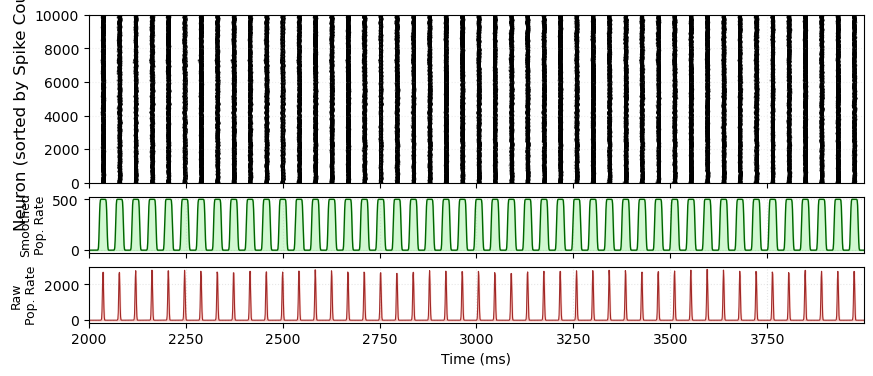

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


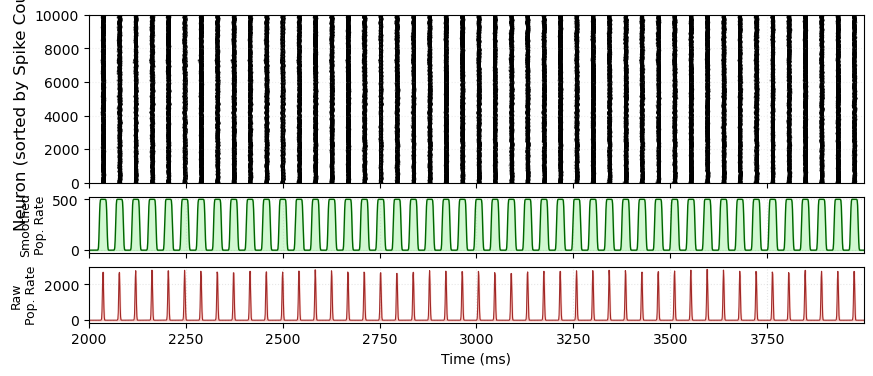

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


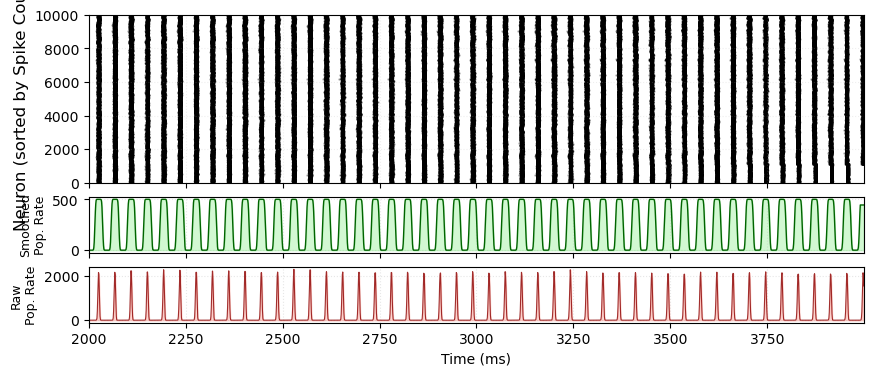

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


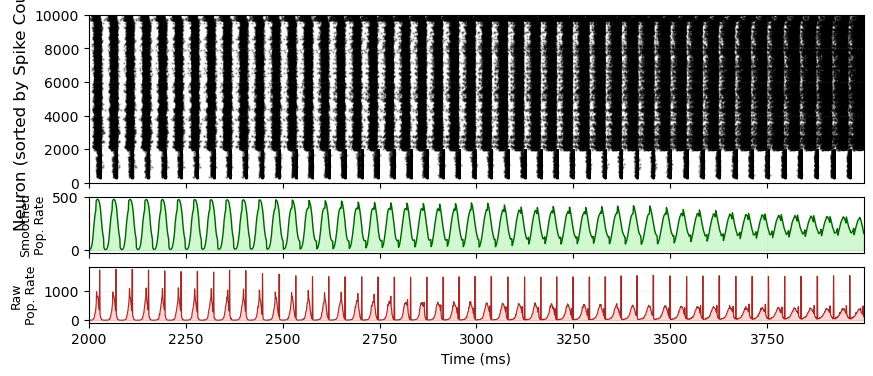

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


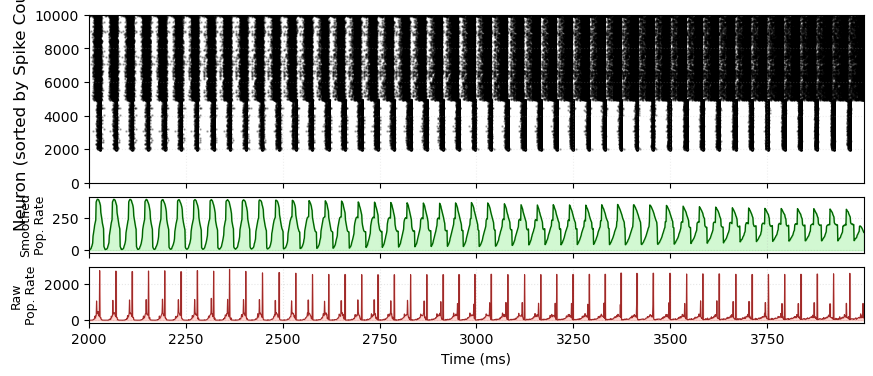

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


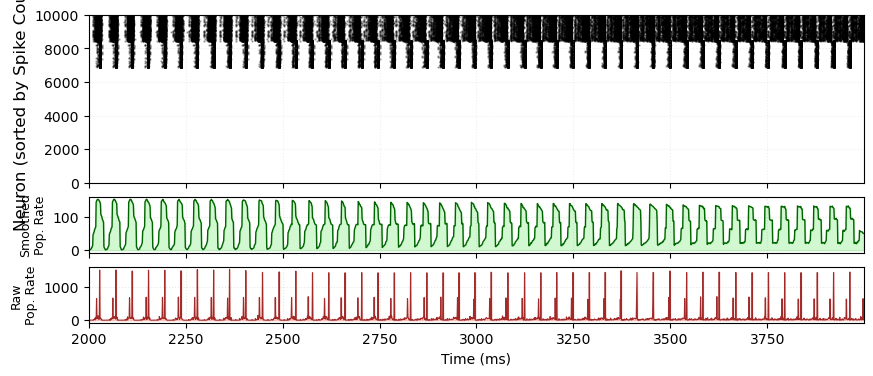

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


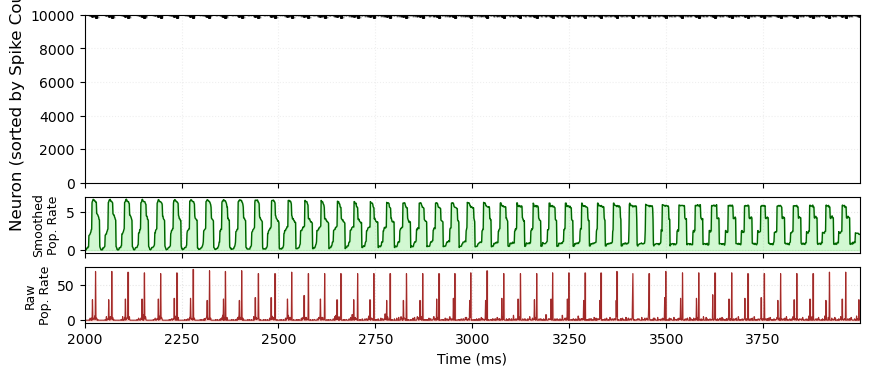

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
def plot_sorted_raster(snapshot_time, sort_by='spike_count', show_last_fraction=0.5):
    folder = f"spiking_results_t{snapshot_time:04d}"
    
    # Load data
    spikes = np.load(os.path.join(folder, "spikes.npy"))
    neuron_info = pd.read_csv(os.path.join(folder, "neuron_info.csv"))
    
    N, T_total = spikes.shape
    start_idx = int(T_total * (1 - show_last_fraction))
    spikes_plot = spikes[:, start_idx:]
    T_plot = spikes_plot.shape[1]
    time_plot = np.arange(T_plot) + start_idx

    isolated_mask = neuron_info['isolated'].values
    connected_mask = ~isolated_mask

    # --- CORRECTION : tri SEULEMENT sur les connectés ---
    if sort_by == 'spike_count':
        # Compte les spikes DANS LA FENÊTRE AFFICHÉE (plus pertinent)
        sort_key_connected = np.sum(spikes_plot[connected_mask], axis=1)
        sort_label = "Spike Count"#.format(int(show_last_fraction*100))
    elif sort_by == 'in_degree':
        sort_key_connected = neuron_info.loc[connected_mask, 'in_degree'].values
        sort_label = "In-Degree"
    else:
        raise ValueError("sort_by must be 'spike_count' or 'in_degree'")

    # Indices des connectés
    connected_indices = np.where(connected_mask)[0]
    isolated_indices = np.where(isolated_mask)[0]

    # Trier LES CONNECTÉS uniquement
    if len(connected_indices) > 0:
        # Obtenir les indices triés par activité (décroissant)
        sorted_connected_idx = np.argsort(sort_key_connected)[::1]
        connected_sorted = connected_indices[sorted_connected_idx]
    else:
        connected_sorted = np.array([], dtype=int)

    # Les isolés : on les met TOUS en bas, dans n'importe quel ordre (ex: par ID)
    if len(isolated_indices) > 0:
        # Optionnel : trier les isolés par ID pour reproductibilité
        isolated_sorted = np.sort(isolated_indices)
    else:
        isolated_sorted = np.array([], dtype=int)

    # Ordre final : CONNECTÉS (actifs en haut) + ISOLÉS (en bas)
    sorted_indices = np.concatenate([ isolated_sorted,connected_sorted])

    # --- Reste du code inchangé ---
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1,1], hspace=0.15)
    ax_raster = fig.add_subplot(gs[0])

    for rank, neuron_id in enumerate(sorted_indices):
        spike_times = time_plot[spikes_plot[neuron_id].astype(bool)]
        if len(spike_times) > 0:
            color = 'red' if isolated_mask[neuron_id] else 'black'
            alpha = 0.7 if isolated_mask[neuron_id] else 0.3
            ax_raster.scatter(spike_times, np.full_like(spike_times, rank), 
                             s=0.5, color=color, alpha=alpha)

    ax_raster.set_ylabel("Neuron (sorted by " + sort_label + ")", fontsize=12)
    #ax_raster.set_title(f"Raster Plot at t = {snapshot_time} months\n"
                       # f"Last {int(show_last_fraction*100)}% of simulation ({time_plot[0]}–{time_plot[-1]} ms)",
                        #fontsize=14, fontweight='bold')
    ax_raster.set_xlim(time_plot[0], time_plot[-1])
    ax_raster.set_ylim(-1, N)
    ax_raster.tick_params(labelbottom=False)
    ax_raster.grid(True, alpha=0.2, linestyle=':')

    # 2. Population rate (lissé)
    pop_rate = np.sum(spikes_plot, axis=0)  # ← FULL network
    window = 20
    if len(pop_rate) >= window:
        kernel = np.ones(window) / window
        pop_rate_smooth = np.convolve(pop_rate, kernel, mode='same')
    else:
        pop_rate_smooth = pop_rate

    ax_smooth = fig.add_subplot(gs[1], sharex=ax_raster)
    ax_smooth.plot(time_plot, pop_rate_smooth, color='darkgreen', linewidth=1)
    ax_smooth.fill_between(time_plot, 0, pop_rate_smooth, color='lightgreen', alpha=0.4)
    ax_smooth.set_ylabel("Smoothed\nPop. Rate", fontsize=9)
    ax_smooth.tick_params(labelbottom=False)
    ax_smooth.grid(True, alpha=0.3, linestyle=':')

    # 3. Population rate (brut, non lissé)
    ax_raw = fig.add_subplot(gs[2], sharex=ax_raster)
    ax_raw.plot(time_plot, pop_rate, color='darkred', linewidth=0.8, alpha=0.8)
    ax_raw.fill_between(time_plot, 0, pop_rate, color='salmon', alpha=0.3)
    ax_raw.set_ylabel("Raw\nPop. Rate", fontsize=9)
    ax_raw.set_xlabel("Time (ms)")
    ax_raw.grid(True, alpha=0.3, linestyle=':')

    plt.tight_layout()
    plt.savefig(f"raster_sorted_{sort_by}_t{snapshot_time}pct.png", 
                dpi=200, bbox_inches='tight')
    plt.show()
# Afficher les 50% derniers (2000–4000 ms)
plot_sorted_raster(10, sort_by='spike_count', show_last_fraction=0.5)
plot_sorted_raster(100, sort_by='spike_count', show_last_fraction=0.5)
#plot_sorted_raster(200, sort_by='spike_count', show_last_fraction=0.5)
plot_sorted_raster(200, sort_by='spike_count', show_last_fraction=0.5)
plot_sorted_raster(260, sort_by='spike_count', show_last_fraction=0.5)
plot_sorted_raster(275, sort_by='spike_count', show_last_fraction=0.5)
plot_sorted_raster(300, sort_by='spike_count', show_last_fraction=0.5)
plot_sorted_raster(350, sort_by='spike_count', show_last_fraction=0.5)
# Ou les 25% derniers (2000–4000 ms)
#plot_sorted_raster(300, sort_by='in_degree', show_last_fraction=0.5)

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


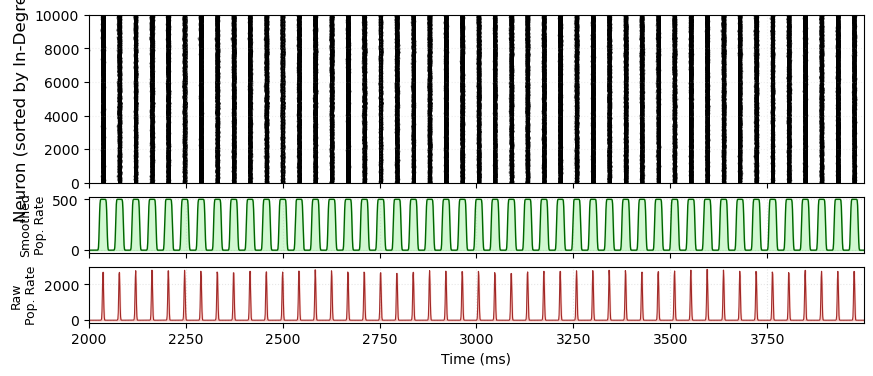

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


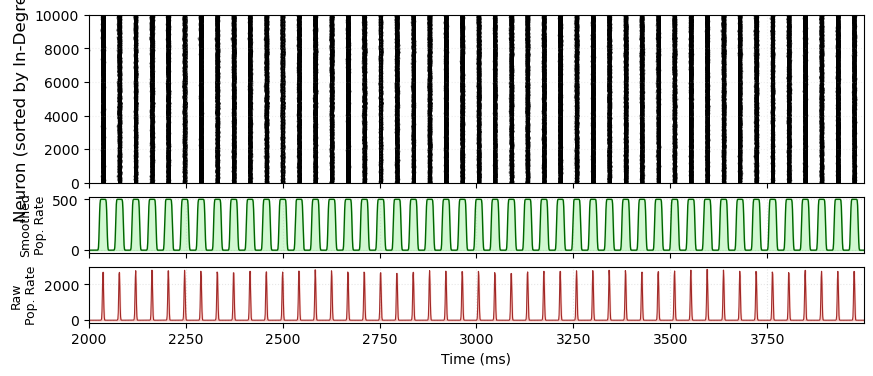

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


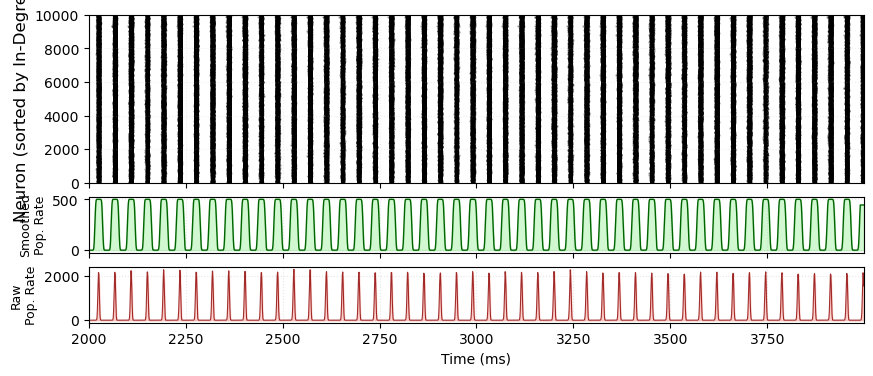

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


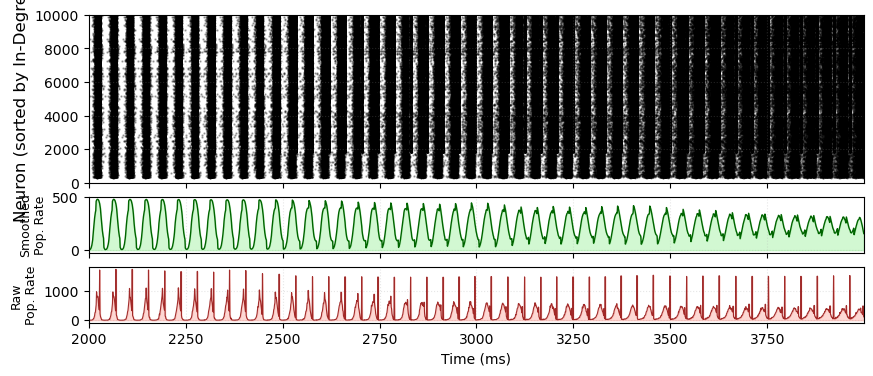

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


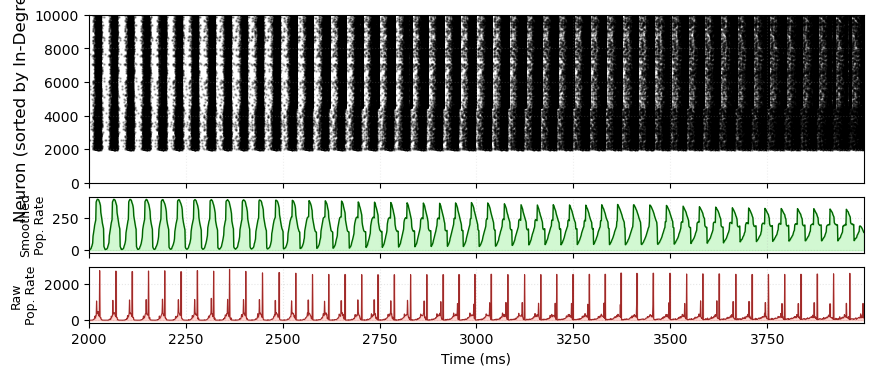

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


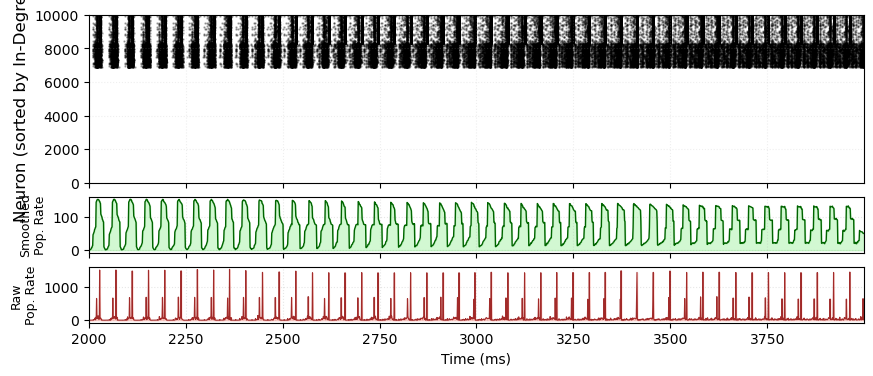

C:\Users\User\AppData\Local\Temp\ipykernel_29568\2299988126.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


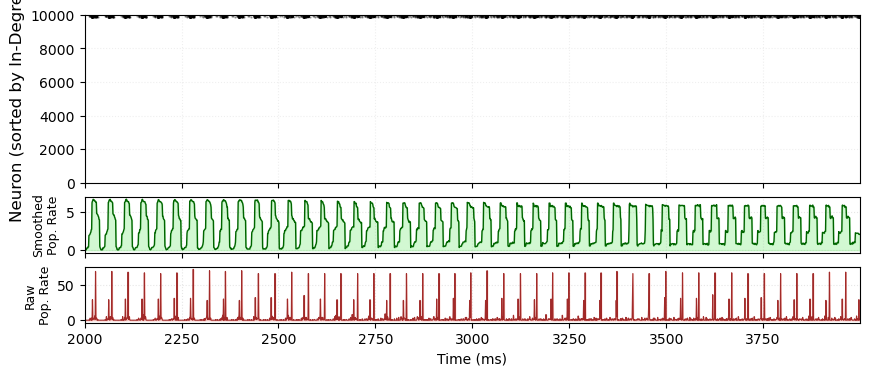

In [11]:
plot_sorted_raster(10, sort_by='in_degree', show_last_fraction=0.5)
plot_sorted_raster(100, sort_by='in_degree', show_last_fraction=0.5)
plot_sorted_raster(200, sort_by='in_degree', show_last_fraction=0.5)
plot_sorted_raster(260, sort_by='in_degree', show_last_fraction=0.5)
plot_sorted_raster(275, sort_by='in_degree', show_last_fraction=0.5)
plot_sorted_raster(300, sort_by='in_degree', show_last_fraction=0.5)
plot_sorted_raster(350, sort_by='in_degree', show_last_fraction=0.5)

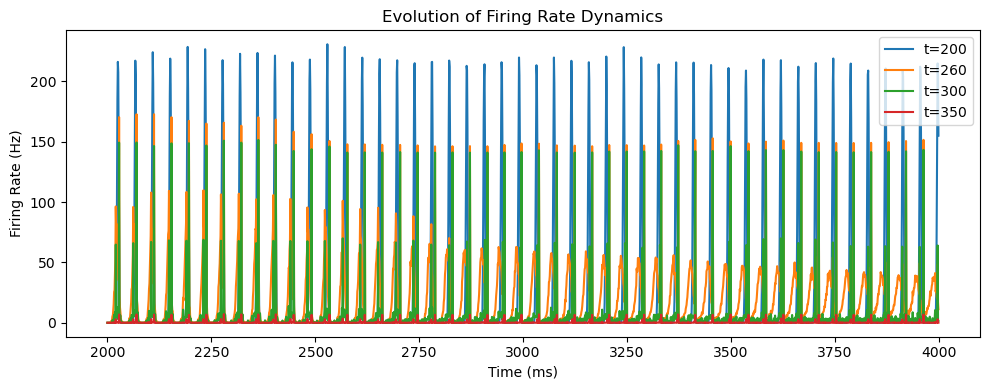

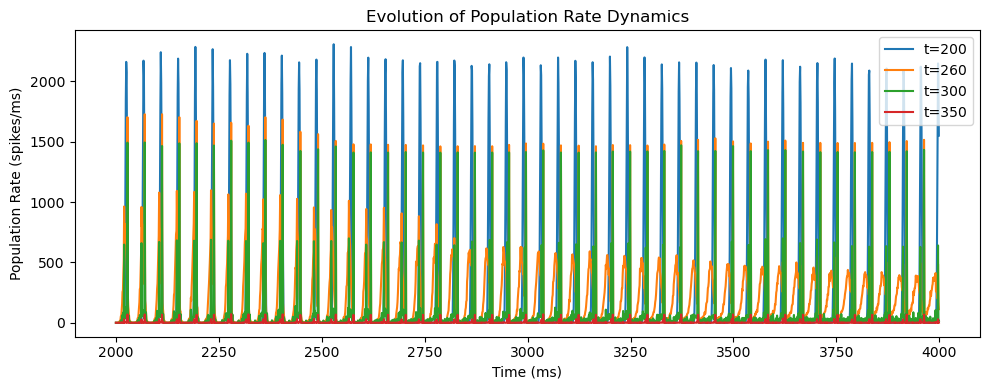

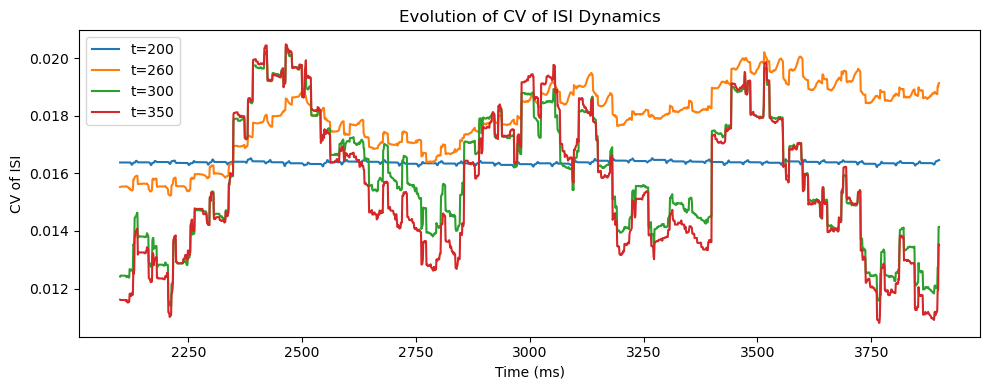

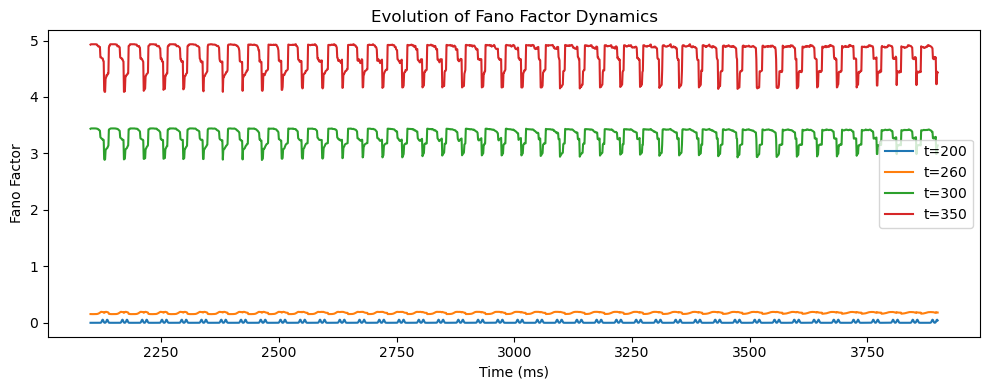

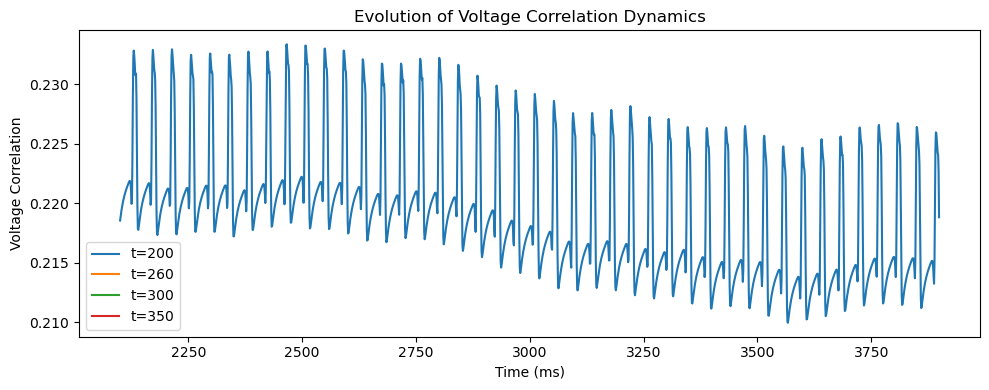

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

stages = [200, 260, 300, 350]

# 1. Firing Rate
plt.figure(figsize=(10, 4))
for t in stages:
    df = pd.read_csv(f"time_resolved_metrics_t{t:04d}.csv")
    plt.plot(df['time_ms'], df['instant_firing_rate_Hz'], label=f't={t}')
plt.xlabel("Time (ms)")
plt.ylabel("Firing Rate (Hz)")
plt.legend()
plt.title("Evolution of Firing Rate Dynamics")
plt.tight_layout()
plt.savefig("firing_rate_dynamics.png", dpi=200, bbox_inches='tight')
plt.show()

# 2. Population Rate
plt.figure(figsize=(10, 4))
for t in stages:
    df = pd.read_csv(f"time_resolved_metrics_t{t:04d}.csv")
    plt.plot(df['time_ms'], df['pop_rate_spikes_per_ms'], label=f't={t}')
plt.xlabel("Time (ms)")
plt.ylabel("Population Rate (spikes/ms)")
plt.legend()
plt.title("Evolution of Population Rate Dynamics")
plt.tight_layout()
plt.savefig("population_rate_dynamics.png", dpi=200, bbox_inches='tight')
plt.show()

# 3. CV of ISI
plt.figure(figsize=(10, 4))
for t in stages:
    df = pd.read_csv(f"time_resolved_metrics_t{t:04d}.csv")
    plt.plot(df['time_ms'], df['instant_cv_isi'], label=f't={t}')
plt.xlabel("Time (ms)")
plt.ylabel("CV of ISI")
plt.legend()
plt.title("Evolution of CV of ISI Dynamics")
plt.tight_layout()
plt.savefig("cv_isi_dynamics.png", dpi=200, bbox_inches='tight')
plt.show()

# 4. Fano Factor
plt.figure(figsize=(10, 4))
for t in stages:
    df = pd.read_csv(f"time_resolved_metrics_t{t:04d}.csv")
    plt.plot(df['time_ms'], df['instant_fano_factor'], label=f't={t}')
plt.xlabel("Time (ms)")
plt.ylabel("Fano Factor")
plt.legend()
plt.title("Evolution of Fano Factor Dynamics")
plt.tight_layout()
plt.savefig("fano_factor_dynamics.png", dpi=200, bbox_inches='tight')
plt.show()

# 5. Voltage Correlation
plt.figure(figsize=(10, 4))
for t in stages:
    df = pd.read_csv(f"time_resolved_metrics_t{t:04d}.csv")
    plt.plot(df['time_ms'], df['instant_voltage_corr'], label=f't={t}')
plt.xlabel("Time (ms)")
plt.ylabel("Voltage Correlation")
plt.legend()
plt.title("Evolution of Voltage Correlation Dynamics")
plt.tight_layout()
plt.savefig("voltage_correlation_dynamics.png", dpi=200, bbox_inches='tight')
plt.show()

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

def compute_spectral_analysis_full_network(spikes, v_time, dt_ms=1, tmin_ms=2000, max_freq=100):
    """
    Compute FFT of population activity using the FULL network (connected + isolated neurons).
    
    Parameters:
        spikes: (N, T) binary spike trains
        v_time: (N, T) membrane potentials
        dt_ms: simulation timestep in ms
        tmin_ms: start time for analysis (ms)
        max_freq: max frequency to consider for dominant freq (Hz)
    
    Returns:
        dict with frequencies, power spectra, dominant frequency, etc.
    """
    N, T_total = spikes.shape
    start_idx = int(tmin_ms / dt_ms)
    end_idx = T_total
    T_analyze = end_idx - start_idx

    if T_analyze <= 0:
        return None

    # Use FULL network — no masking
    spikes_analyze = spikes[:, start_idx:end_idx]  # (N, T)
    v_analyze = v_time[:, start_idx:end_idx]       # (N, T)

    # 1. Population rate = total spikes per ms (all neurons)
    pop_rate = np.sum(spikes_analyze, axis=0).astype(float)

    # 2. Mean membrane potential over ALL neurons
    mean_v = np.mean(v_analyze, axis=0)

    # 3. FFT helper
    def get_power_spectrum(signal):
        signal = signal - np.mean(signal)  # remove DC
        yf = fft(signal)
        xf = fftfreq(len(signal), d=dt_ms / 1000.0)  # dt in seconds
        # Keep only non-negative frequencies
        pos_mask = xf >= 0
        return xf[pos_mask], np.abs(yf[pos_mask])**2  # power

    freq_pop, power_pop = get_power_spectrum(pop_rate)
    freq_v, power_v = get_power_spectrum(mean_v)

    # 4. Dominant frequency (0 to max_freq Hz)
    valid = freq_pop <= max_freq
    if np.any(valid):
        dominant_freq = freq_pop[valid][np.argmax(power_pop[valid])]
    else:
        dominant_freq = np.nan

    return {
        "frequencies": freq_pop,
        "power_population_rate": power_pop,
        "power_mean_v": power_v,
        "dominant_frequency": dominant_freq,
        "time_vector": np.arange(start_idx, end_idx) * dt_ms
    }

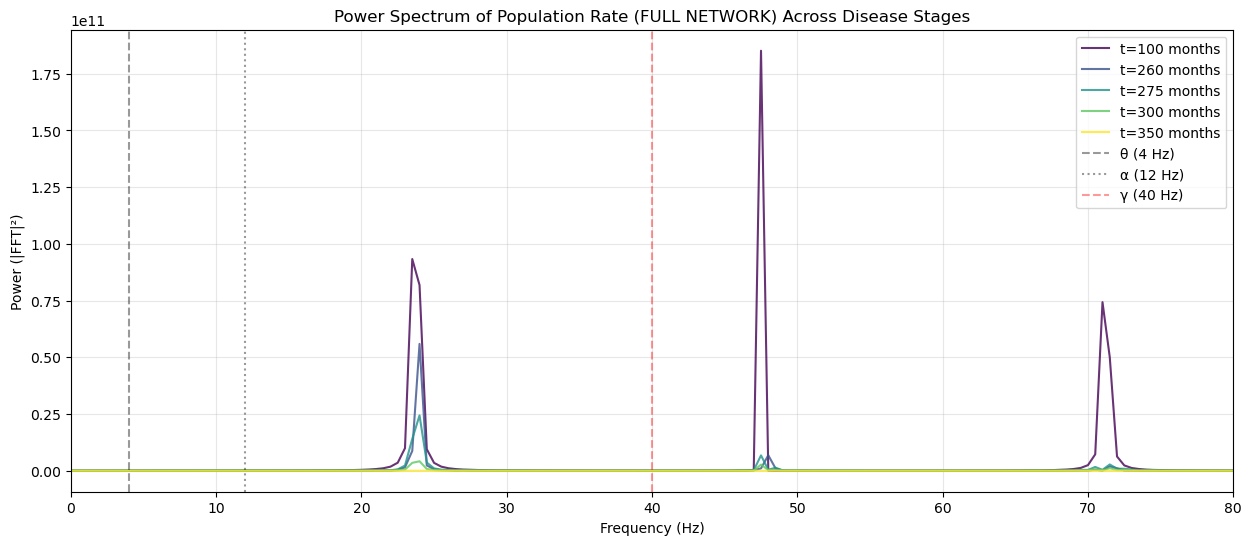

In [22]:
#--- Main: compute and plot spectra for all snapshots (FULL network) ---
snapshot_times =[100,260,275,300,350]# [10,50, 200, 250, 265, 300, 350, 400]
spectral_results = {}

plt.figure(figsize=(15, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(snapshot_times)))

for i, t in enumerate(snapshot_times):
    folder = f"spiking_results_t{t:04d}"
    if not os.path.exists(folder):
        print(f"⚠️ Skipping t={t}")
        continue

    spikes = np.load(os.path.join(folder, "spikes.npy"))
    v_time = np.load(os.path.join(folder, "v_time.npy"))
    # Note: isolated_mask is no longer needed

    spec = compute_spectral_analysis_full_network(
        spikes, v_time, dt_ms=1, tmin_ms=2000, max_freq=100
    )
    
    if spec is None:
        continue

    spectral_results[t] = spec

    plt.plot(spec["frequencies"], spec["power_population_rate"], 
             color=colors[i], label=f't={t} months', alpha=0.8)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (|FFT|²)")
plt.title("Power Spectrum of Population Rate (FULL NETWORK) Across Disease Stages")
plt.xlim(0, 80)
plt.axvline(4, color='black', linestyle='--', alpha=0.4, label='θ (4 Hz)')
plt.axvline(12, color='black', linestyle=':', alpha=0.4, label='α (12 Hz)')
plt.axvline(40, color='red', linestyle='--', alpha=0.4, label='γ (40 Hz)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("spectral_evolution_FULL_network.png", dpi=200, bbox_inches='tight')
plt.show()

Loaded metrics for t = 10
Loaded metrics for t = 100
Loaded metrics for t = 200
Loaded metrics for t = 260
Loaded metrics for t = 275
Loaded metrics for t = 300
Loaded metrics for t = 350


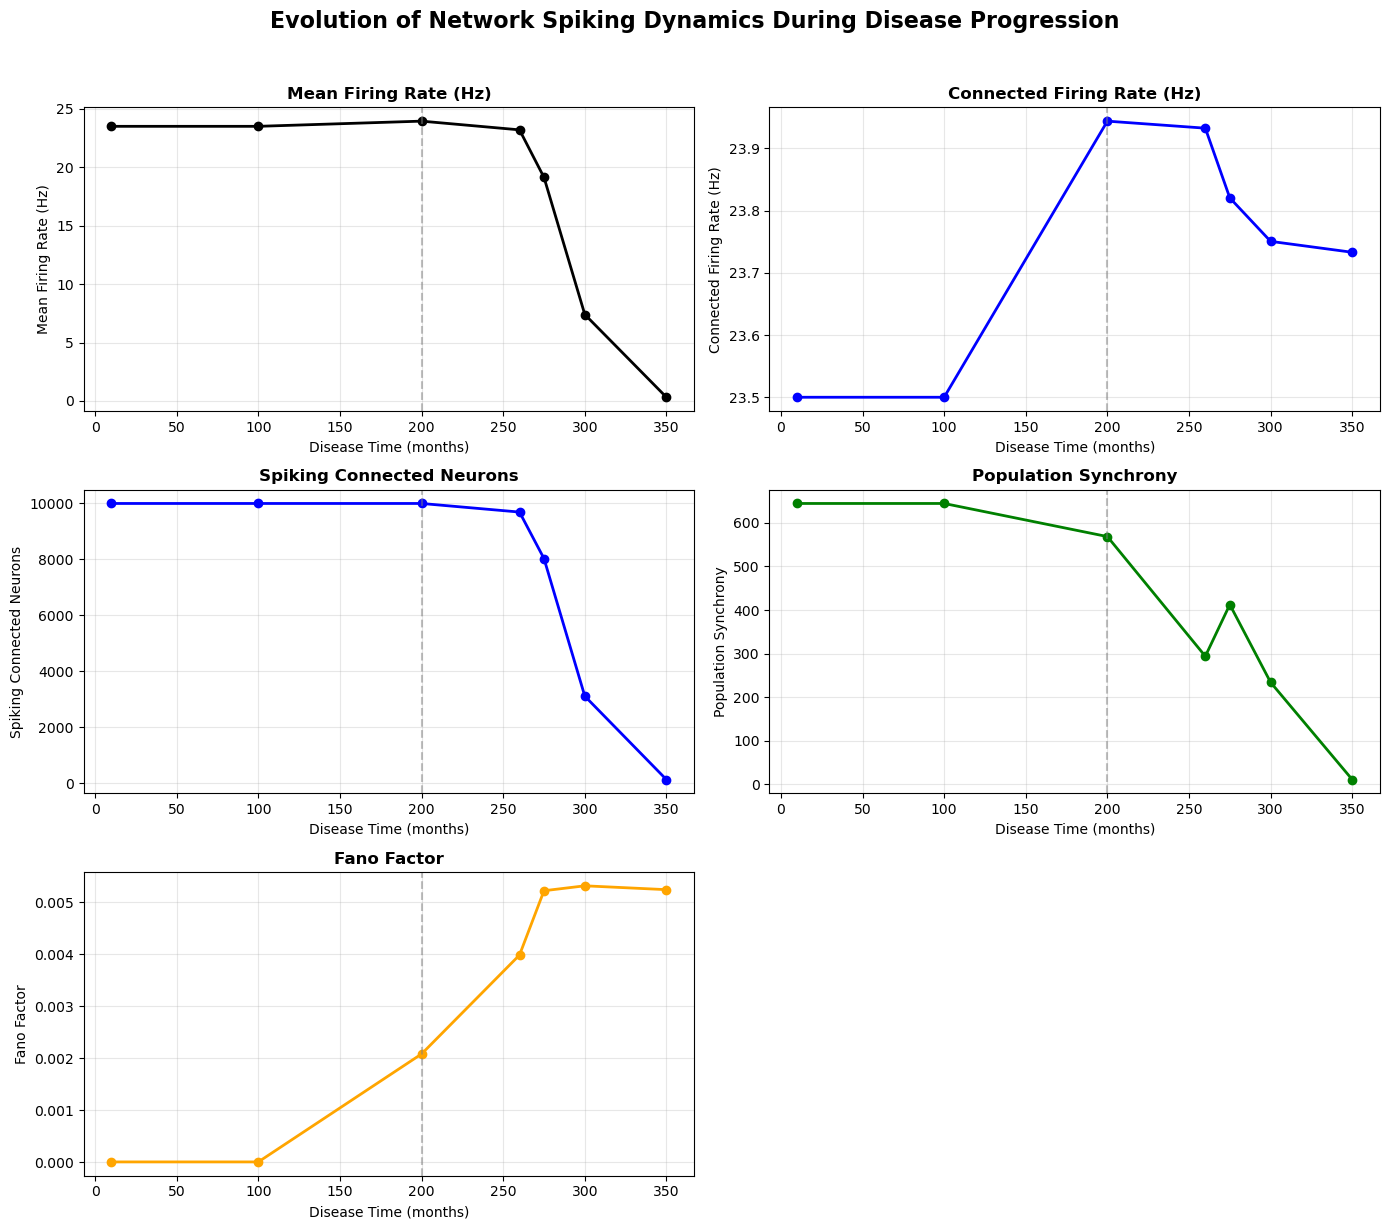

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Define snapshot times (must match your simulation) ---
snapshot_times =  [10, 100, 200, 260, 275, 300, 350]

# --- 2. Collect metrics from each folder ---
all_metrics = []

for t in snapshot_times:
    folder = f"spiking_results_t{t:04d}"
    metrics_file = os.path.join(folder, "spike_metrics.csv")
    
    if os.path.exists(metrics_file):
        df = pd.read_csv(metrics_file)
        metrics_dict = df.iloc[0].to_dict()  # first (and only) row
        metrics_dict['snapshot_time'] = t
        all_metrics.append(metrics_dict)
        print(f"Loaded metrics for t = {t}")
    else:
        print(f"⚠️ Missing metrics for t = {t}")
        # Add placeholder with NaNs if needed
        all_metrics.append({'snapshot_time': t})

# Convert to DataFrame
metrics_df = pd.DataFrame(all_metrics).set_index('snapshot_time').reindex(snapshot_times)

# --- 3. Define which metrics to plot ---
metrics_to_plot = [
    ('mean_firing_rate_all', 'Mean Firing Rate (Hz)', 'black'),
    ('mean_firing_rate_connected', 'Connected Firing Rate (Hz)', 'blue'),
    #('mean_firing_rate_isolated', 'Isolated Firing Rate (Hz)', 'red'),
    ('connected_spiking', 'Spiking Connected Neurons', 'blue'),
    #('isolated_spiking', 'Spiking Isolated Neurons', 'red'),
    ('population_synchrony', 'Population Synchrony', 'green')
    #('burst_index', 'Burst Index', 'purple'),
    
]

# --- 4. Plot all metrics ---
n_metrics = len(metrics_to_plot)
n_cols = 2
n_rows = (n_metrics + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten() if n_metrics > 1 else [axes]

for idx, (col, title, color) in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    if col in metrics_df.columns:
        y = metrics_df[col]
        ax.plot(snapshot_times, y, 'o-', color=color, linewidth=2, markersize=6)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel("Disease Time (months)")
        ax.set_ylabel(title)
        ax.grid(True, alpha=0.3)
        
        # Highlight decline (optional)
        if not y.isna().all():
            ax.axvline(x=200, color='gray', linestyle='--', alpha=0.5)  # e.g., onset
    else:
        ax.text(0.5, 0.5, f"Metric '{col}'\nnot found", 
                transform=ax.transAxes, ha='center', va='center')
        ax.set_title(title)

# Hide unused subplots
for idx in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("Evolution of Network Spiking Dynamics During Disease Progression", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("spiking_metrics_evolution.png", dpi=150, bbox_inches='tight')
plt.show()

In [5]:
def compute_golomb_synchrony(v_time, dt_ms=1, window_ms=200):
    """
    Compute Golomb's chi(N) synchrony measure in sliding windows.
    v_time: (N, T) membrane potentials
    Returns: time vector, chi_values
    """
    N, T = v_time.shape
    window_size = int(window_ms / dt_ms)
    chi_values = np.full(T, np.nan)
    time_ms = np.arange(T) * dt_ms

    for t_center in range(window_size//2, T - window_size//2):
        t0 = t_center - window_size//2
        t1 = t0 + window_size
        V_window = v_time[:, t0:t1]  # (N, W)

        # Population average over time
        V_mean_over_neurons = np.mean(V_window, axis=0)  # (W,)
        sigma_V_sq = np.var(V_mean_over_neurons)

        # Single-neuron variances
        sigma_Vi_sq = np.var(V_window, axis=1)  # (N,)
        avg_sigma_Vi_sq = np.mean(sigma_Vi_sq)

        if avg_sigma_Vi_sq > 0:
            chi_sq = sigma_V_sq / avg_sigma_Vi_sq
            chi_values[t_center] = np.sqrt(chi_sq)
        else:
            chi_values[t_center] = 0

    return time_ms, chi_values

In [10]:
import numpy as np
import pandas as pd

def compute_golomb_synchrony1(v_time, neuron_info_file, dt_ms=1, window_ms=100):
    """
    Compute Golomb synchrony χ using only CONNECTED neurons.
    
    Parameters:
        v_time: (N, T) array of membrane potentials
        neuron_info_file: path to 'neuron_info.csv'
        dt_ms: timestep in ms
        window_ms: sliding window size for χ(t)
    
    Returns:
        time_points (ms), chi_values
    """
    # Load isolation mask
    neuron_info = pd.read_csv(neuron_info_file)
    isolated = neuron_info['isolated'].values
    connected_mask = ~isolated
    
    # Select only connected neurons
    v_connected = v_time[connected_mask, :]  # (N_conn, T)
    N_conn = v_connected.shape[0]
    
    if N_conn == 0:
        print("⚠️ No connected neurons → χ undefined.")
        return np.array([]), np.array([])
    if N_conn == 1:
        print("⚠️ Only 1 connected neuron → χ undefined (needs ≥2).")
        return np.array([]), np.array([])

    T = v_connected.shape[1]
    window_size = int(window_ms / dt_ms)
    if window_size > T:
        print(f"⚠️ Window size ({window_ms} ms) > simulation time. Skipping χ.")
        return np.array([]), np.array([])

    step = max(1, window_size // 2)  # 50% overlap, min step=1
    chi_values = []
    time_points = []

    for start in range(0, T - window_size + 1, step):
        end = start + window_size
        V_win = v_connected[:, start:end]  # (N_conn, window)

        # Mean membrane potential across neurons (over space)
        V_mean = np.mean(V_win, axis=0)  # (window,)
        
        # Variance of this mean over TIME → numerator
        var_mean = np.var(V_mean)
        
        # Variance of each neuron over TIME → then average → denominator
        var_individual = np.var(V_win, axis=1)  # (N_conn,)
        mean_var_individual = np.mean(var_individual)
        
        # Compute χ
        if mean_var_individual == 0:
            chi = np.nan  # no fluctuation in any neuron
        else:
            chi = var_mean / mean_var_individual
        
        chi_values.append(chi)
        time_points.append(start + window_size // 2)

    return np.array(time_points) * dt_ms, np.array(chi_values)

<function matplotlib.pyplot.show(close=None, block=None)>

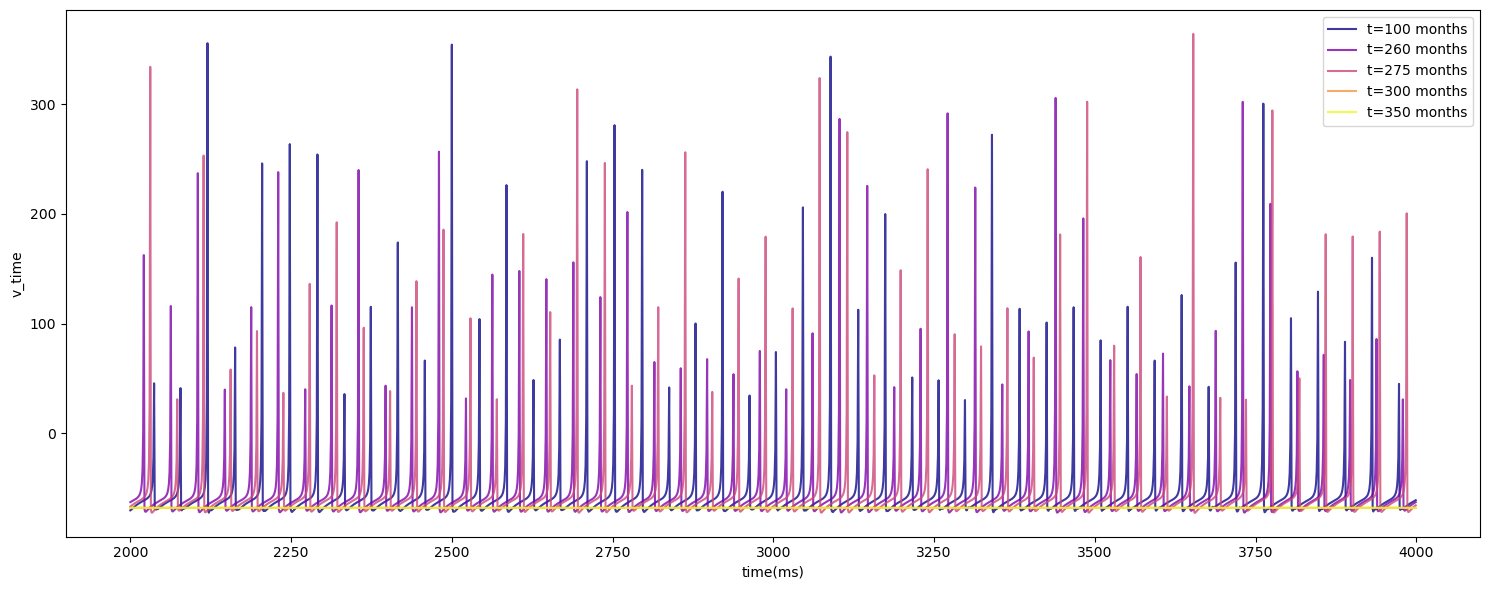

In [41]:
snapshot_times =[100,260,275,300,350]# [10,50, 200, 250, 265, 300, 350, 400]
spectral_results = {}

plt.figure(figsize=(15, 6))
colors = plt.cm.plasma(np.linspace(0, 1, len(snapshot_times)))

for i, t in enumerate(snapshot_times):
    folder = f"spiking_results_t{t:04d}"
    if not os.path.exists(folder):
        print(f"⚠️ Skipping t={t}")
        continue

    #spikes = np.load(os.path.join(folder, "spikes.npy"))
    v_time = np.load(os.path.join(folder, "v_time.npy"))
    # Note: isolated_mask is no longer needed

    #time_ms, chi_values = compute_golomb_synchrony(
    #    v_time, dt_ms=1, window_ms=100
    #)
    #avg_chi = np.mean(chi_values[2000:])  # exclude transient
    #if spec is None:
     #   continue

    #spectral_results[t] = spec

    plt.plot(time_ms[2000:], v_time[15,2000:], 
             color=colors[i], label=f't={t} months', alpha=0.8)

plt.xlabel("time(ms)")
plt.ylabel("v_time")

plt.legend()
plt.tight_layout()
plt.savefig("V_time().png", dpi=300, bbox_inches='tight')
plt.show


ModuleNotFoundError: No module named 'pyspike'

In [54]:
import numpy as np
import pandas as pd
import os

def compute_time_resolved_metrics(spikes, v_time, isolated_mask, dt_ms=1, tmin_ms=2000, window_ms=100):
    """
    Compute time-resolved metrics over the analysis window.
    
    Parameters:
        spikes: (N, T) binary
        v_time: (N, T) membrane potential
        isolated_mask: (N,) boolean
        window_ms: sliding window size (for CV, FF, etc.)
    
    Returns:
        dict with time series for each metric
    """
    N, T_total = spikes.shape
    start_idx = int(tmin_ms / dt_ms)
    end_idx = T_total
    T_analyze = end_idx - start_idx
    
    if T_analyze <= 0:
        empty = np.array([])
        return {
            "time_ms": empty,
            "instant_firing_rate": empty,
            "pop_rate": empty,
            "instant_cv_isi": empty,
            "instant_fano_factor": empty,
            "instant_voltage_corr": empty
        }

    # Subsets
    spikes_analyze = spikes[:, start_idx:end_idx]  # (N, T)
    v_analyze = v_time[:, start_idx:end_idx]       # (N, T)
    connected_mask = ~isolated_mask
    time_ms = np.arange(start_idx, end_idx) * dt_ms  # ex: 2000, 2001, ..., 3999

    # 1. Instantaneous population rate (spikes per ms)
    pop_rate = np.sum(spikes_analyze[connected_mask], axis=0)  # (T,)
    
    # 2. Instant firing rate (mean over neurons, in Hz)
    N_conn = np.sum(connected_mask)
    if N_conn > 0:
        instant_firing_rate = (pop_rate / N_conn) * (1000 / dt_ms)  # Hz
    else:
        instant_firing_rate = np.zeros_like(pop_rate)

    # 3. Time-resolved CV of ISI (using sliding window)
    window_size = int(window_ms / dt_ms)
    instant_cv_isi = np.full(T_analyze, np.nan)
    instant_fano_factor = np.full(T_analyze, np.nan)
    
    if N_conn > 0 and window_size < T_analyze:
        for t_center in range(window_size//2, T_analyze - window_size//2):
            t_start = t_center - window_size//2
            t_end = t_start + window_size
            window_spikes = spikes_analyze[connected_mask, t_start:t_end]
            
            # Fano Factor for this window
            spike_counts_win = np.sum(window_spikes, axis=1)
            if np.mean(spike_counts_win) > 0:
                instant_fano_factor[t_center] = np.var(spike_counts_win) / np.mean(spike_counts_win)
            
            # CV of ISI: collect all ISIs in window
            all_isi = []
            for i in range(len(connected_mask)):
                if connected_mask[i]:
                    spike_times = np.where(window_spikes[np.where(connected_mask)[0] == i][0])[0]
                    if len(spike_times) >= 2:
                        isi = np.diff(spike_times) * dt_ms
                        all_isi.extend(isi)
            if len(all_isi) >= 2:
                instant_cv_isi[t_center] = np.std(all_isi) / np.mean(all_isi)

    # 4. Time-resolved voltage correlation (sliding window)
    instant_voltage_corr = np.full(T_analyze, np.nan)
    if N_conn >= 2 and window_size < T_analyze:
        for t_center in range(window_size//2, T_analyze - window_size//2):
            t_start = t_center - window_size//2
            t_end = t_start + window_size
            v_win = v_analyze[connected_mask, t_start:t_end]
            v_centered = v_win - np.mean(v_win, axis=1, keepdims=True)
            cov_mat = np.cov(v_centered)
            off_diag = cov_mat[~np.eye(cov_mat.shape[0], dtype=bool)]
            if len(off_diag) > 0:
                instant_voltage_corr[t_center] = np.mean(off_diag)

    return {
        "time_ms": time_ms,
        "instant_firing_rate": instant_firing_rate,
        "pop_rate": pop_rate,
        "instant_cv_isi": instant_cv_isi,
        "instant_fano_factor": instant_fano_factor,
        "instant_voltage_corr": instant_voltage_corr
    }

# --- Main: compute and save time-resolved metrics for each snapshot ---
snapshot_times = [10,50, 200, 250, 265, 300, 350, 400]

for t in snapshot_times:
    folder = f"spiking_results_t{t:04d}"
    if not os.path.exists(folder):
        print(f"⚠️ Skipping t={t}")
        continue

    spikes = np.load(os.path.join(folder, "spikes.npy"))
    v_time = np.load(os.path.join(folder, "v_time.npy"))
    neuron_info = pd.read_csv(os.path.join(folder, "neuron_info.csv"))
    isolated_mask = neuron_info['isolated'].values

    metrics_ts = compute_time_resolved_metrics(
        spikes, v_time, isolated_mask,
        dt_ms=1, tmin_ms=2000, window_ms=200  # 200 ms windows
    )

    # Save as CSV
    df_ts = pd.DataFrame({
        'time_ms': metrics_ts['time_ms'],
        'instant_firing_rate_Hz': metrics_ts['instant_firing_rate'],
        'pop_rate_spikes_per_ms': metrics_ts['pop_rate'],
        'instant_cv_isi': metrics_ts['instant_cv_isi'],
        'instant_fano_factor': metrics_ts['instant_fano_factor'],
        'instant_voltage_corr': metrics_ts['instant_voltage_corr']
    })
    df_ts.to_csv(f"time_resolved_metrics_t{t:04d}.csv", index=False)
    print(f"✅ Saved time-resolved metrics for t={t}")

✅ Saved time-resolved metrics for t=50
✅ Saved time-resolved metrics for t=150
✅ Saved time-resolved metrics for t=200
✅ Saved time-resolved metrics for t=250
✅ Saved time-resolved metrics for t=300
✅ Saved time-resolved metrics for t=350


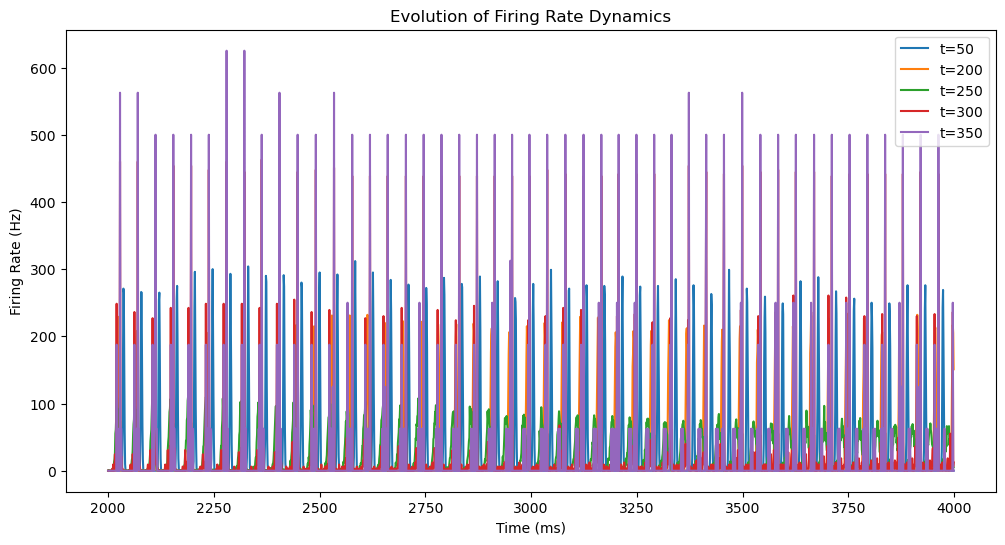

In [55]:
plt.figure(figsize=(12, 6))
for t in [50, 200,250,300, 350]:
    df = pd.read_csv(f"time_resolved_metrics_t{t:04d}.csv")
    plt.plot(df['time_ms'], df['instant_firing_rate_Hz'], label=f't={t}')
plt.xlabel("Time (ms)"); plt.ylabel("Firing Rate (Hz)")
plt.legend(); plt.title("Evolution of Firing Rate Dynamics")
plt.show()

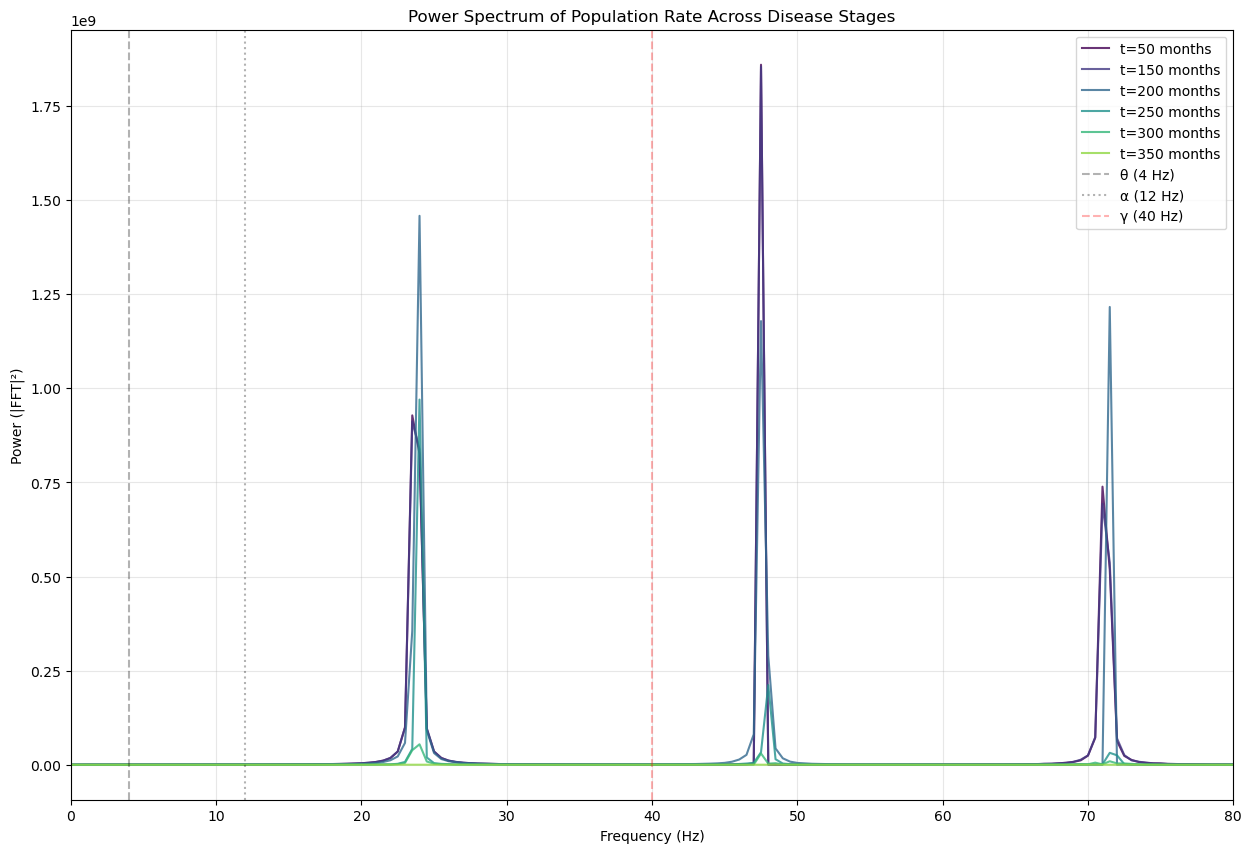

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift

def compute_spectral_analysis(spikes, v_time, isolated_mask, dt_ms=1, tmin_ms=2000, max_freq=100):
    """
    Compute FFT of population activity for spectral analysis.
    
    Returns:
        dict with frequencies, power spectra, and dominant frequency
    """
    N, T_total = spikes.shape
    start_idx = int(tmin_ms / dt_ms)
    end_idx = T_total
    T_analyze = end_idx - start_idx
    
    if T_analyze <= 0:
        return None

    # Subsets
    spikes_analyze = spikes[:, start_idx:end_idx]
    v_analyze = v_time[:, start_idx:end_idx]
    connected_mask = ~isolated_mask

    # 1. Population rate (spikes per ms)
    pop_rate = np.sum(spikes_analyze[connected_mask], axis=0).astype(float)
    
    # 2. Mean membrane potential (sub-threshold dynamics)
    if np.sum(connected_mask) > 0:
        mean_v = np.mean(v_analyze[connected_mask], axis=0)
    else:
        mean_v = np.zeros_like(pop_rate)

    # 3. FFT for both signals
    def get_spectrum(signal):
        # Remove mean (DC component)
        signal = signal - np.mean(signal)
        # FFT
        yf = fft(signal)
        xf = fftfreq(len(signal), dt_ms / 1000.0)  # dt in seconds
        # Only positive frequencies
        idx = xf >= 0
        return xf[idx], np.abs(yf[idx])**2  # power = |FFT|^2

    freq_pop, power_pop = get_spectrum(pop_rate)
    freq_v, power_v = get_spectrum(mean_v)

    # 4. Find dominant frequency (0 to max_freq Hz)
    max_idx = freq_pop <= max_freq
    if np.any(max_idx):
        dominant_freq = freq_pop[max_idx][np.argmax(power_pop[max_idx])]
    else:
        dominant_freq = np.nan

    return {
        "frequencies": freq_pop,
        "power_population_rate": power_pop,
        "power_mean_v": power_v,
        "dominant_frequency": dominant_freq,
        "time_vector": np.arange(start_idx, end_idx) * dt_ms
    }

# --- Main: compute and plot spectra for all snapshots ---
snapshot_times = [10,50, 200, 250, 265, 300, 350, 400]
spectral_results = {}

plt.figure(figsize=(15, 10))
colors = plt.cm.viridis(np.linspace(0, 1, len(snapshot_times)))

for i, t in enumerate(snapshot_times):
    folder = f"spiking_results_t{t:04d}"
    if not os.path.exists(folder):
        continue

    spikes = np.load(os.path.join(folder, "spikes.npy"))
    v_time = np.load(os.path.join(folder, "v_time.npy"))
    neuron_info = pd.read_csv(os.path.join(folder, "neuron_info.csv"))
    isolated_mask = neuron_info['isolated'].values

    spec = compute_spectral_analysis(spikes, v_time, isolated_mask, dt_ms=1, tmin_ms=2000)
    if spec is None:
        continue

    spectral_results[t] = spec

    # Plot power spectrum (population rate)
    plt.plot(spec["frequencies"], spec["power_population_rate"], 
             color=colors[i], label=f't={t} months', alpha=0.8)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (|FFT|²)")
plt.title("Power Spectrum of Population Rate Across Disease Stages")
plt.xlim(0, 80)  # Focus on biologically relevant bands
plt.axvline(4, color='black', linestyle='--', alpha=0.3, label='θ (4 Hz)')
plt.axvline(12, color='black', linestyle=':', alpha=0.3, label='α (12 Hz)')
plt.axvline(40, color='red', linestyle='--', alpha=0.3, label='γ (40 Hz)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("spectral_evolution_population_rate.png", dpi=200, bbox_inches='tight')
plt.show()

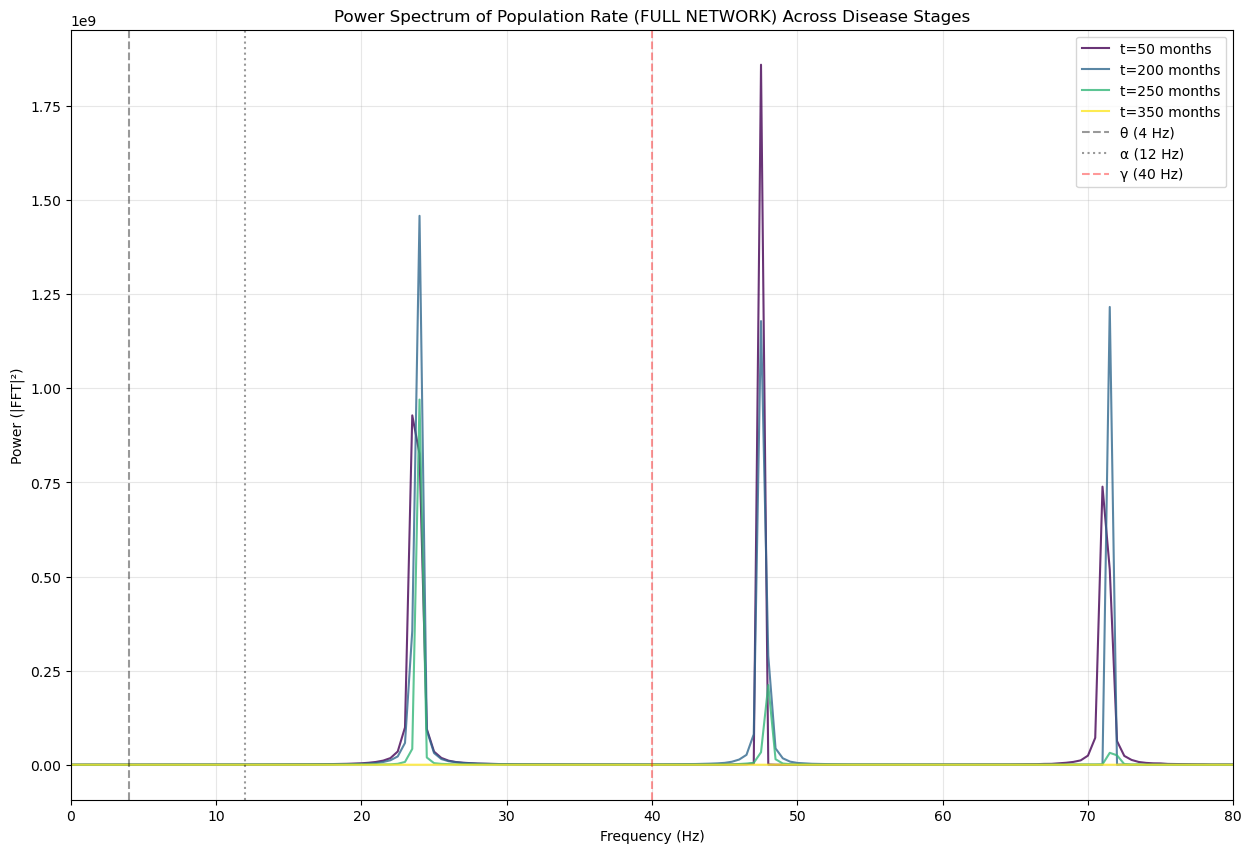

In [61]:
# --- Main: compute and plot spectra for all snapshots (FULL network) ---
snapshot_times =[50,200,250,350]# [10,50, 200, 250, 265, 300, 350, 400]
spectral_results = {}

plt.figure(figsize=(15, 10))
colors = plt.cm.viridis(np.linspace(0, 1, len(snapshot_times)))

for i, t in enumerate(snapshot_times):
    folder = f"spiking_results_t{t:04d}"
    if not os.path.exists(folder):
        print(f"⚠️ Skipping t={t}")
        continue

    spikes = np.load(os.path.join(folder, "spikes.npy"))
    v_time = np.load(os.path.join(folder, "v_time.npy"))
    # Note: isolated_mask is no longer needed

    spec = compute_spectral_analysis_full_network(
        spikes, v_time, dt_ms=1, tmin_ms=2000, max_freq=100
    )
    
    if spec is None:
        continue

    spectral_results[t] = spec

    plt.plot(spec["frequencies"], spec["power_population_rate"], 
             color=colors[i], label=f't={t} months', alpha=0.8)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (|FFT|²)")
plt.title("Power Spectrum of Population Rate (FULL NETWORK) Across Disease Stages")
plt.xlim(0, 80)
plt.axvline(4, color='black', linestyle='--', alpha=0.4, label='θ (4 Hz)')
plt.axvline(12, color='black', linestyle=':', alpha=0.4, label='α (12 Hz)')
plt.axvline(40, color='red', linestyle='--', alpha=0.4, label='γ (40 Hz)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("spectral_evolution_FULL_network.png", dpi=200, bbox_inches='tight')
plt.show()

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

def plot_sorted_raster(snapshot_time, sort_by='spike_count', show_last_fraction=0.5, save_data=False):
    folder = f"spiking_results_t{snapshot_time:04d}"
    output_folder = f"raster_data_t{snapshot_time:04d}"
    if save_data and not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Load data
    spikes = np.load(os.path.join(folder, "spikes.npy"))
    neuron_info = pd.read_csv(os.path.join(folder, "neuron_info.csv"))
    
    N, T_total = spikes.shape
    start_idx = int(T_total * (1 - show_last_fraction))
    spikes_plot = spikes[:, start_idx:]
    T_plot = spikes_plot.shape[1]
    time_plot = np.arange(T_plot) + start_idx

    isolated_mask = neuron_info['isolated'].values
    connected_mask = ~isolated_mask

    # --- Sorting logic (unchanged) ---
    if sort_by == 'spike_count':
        sort_key_connected = np.sum(spikes_plot[connected_mask], axis=1)
        sort_label = "Spike Count"
    elif sort_by == 'in_degree':
        sort_key_connected = neuron_info.loc[connected_mask, 'in_degree'].values
        sort_label = "In-Degree"
    else:
        raise ValueError("sort_by must be 'spike_count' or 'in_degree'")

    connected_indices = np.where(connected_mask)[0]
    isolated_indices = np.where(isolated_mask)[0]

    if len(connected_indices) > 0:
        sorted_connected_idx = np.argsort(sort_key_connected)[::1]  # DESCENDING: most active first
        connected_sorted = connected_indices[sorted_connected_idx]
    else:
        connected_sorted = np.array([], dtype=int)

    isolated_sorted = np.sort(isolated_indices) if len(isolated_indices) > 0 else np.array([], dtype=int)

    # Ordre final : CONNECTÉS (en haut) + ISOLÉS (en bas)
    sorted_indices = np.concatenate([isolated_sorted,connected_sorted])

    if save_data:
        # 1. Sauvegarder l'ordre des neurones (très important pour MATLAB)
        pd.DataFrame({
            'neuron_id': sorted_indices,
            'rank': np.arange(len(sorted_indices)),  # 0 = top, N-1 = bottom
            'is_isolated': isolated_mask[sorted_indices]
        }).to_csv(os.path.join(output_folder, f"neuron_order_{sort_by}.csv"), index=False)

             # 2. SAUVEGARDER SEULEMENT LES ÉVÉNEMENTS DE SPIKE (sparse format)
        spike_events = []
        for rank, neuron_id in enumerate(sorted_indices):
            spike_times = time_plot[spikes_plot[neuron_id].astype(bool)]
            for t_spike in spike_times:
                spike_events.append([t_spike, rank])
        
        if spike_events:
            spike_events = np.array(spike_events)
            np.savetxt(
                os.path.join(output_folder, f"spike_events_{sort_by}.csv"),
                spike_events,
                delimiter=',',
                header='time_ms,neuron_rank',
                comments=''
            )
        else:
            # Fichier vide si pas de spikes
            with open(os.path.join(output_folder, f"spike_events_{sort_by}.csv"), 'w') as f:
                f.write("time_ms,neuron_rank\n")
        # 3. Sauvegarder le temps
        np.savetxt(os.path.join(output_folder, "time_ms.csv"), time_plot, delimiter=',')

        # 4. Population rate (raw and smoothed)
        pop_rate = np.sum(spikes_plot, axis=0)
        window = 20
        if len(pop_rate) >= window:
            kernel = np.ones(window) / window
            pop_rate_smooth = np.convolve(pop_rate, kernel, mode='same')
        else:
            pop_rate_smooth = pop_rate

        pd.DataFrame({
            'time_ms': time_plot,
            'pop_rate_raw': pop_rate,
            'pop_rate_smooth': pop_rate_smooth
        }).to_csv(os.path.join(output_folder, "population_rate.csv"), index=False)

        print(f"✅ Données sauvegardées dans {output_folder}/")

    # --- Plotting (inchangé) ---
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1], hspace=0.15)
    ax_raster = fig.add_subplot(gs[0])

    for rank, neuron_id in enumerate(sorted_indices):
        spike_times = time_plot[spikes_plot[neuron_id].astype(bool)]
        if len(spike_times) > 0:
            color = 'red' if isolated_mask[neuron_id] else 'black'
            alpha = 0.7 if isolated_mask[neuron_id] else 0.3
            ax_raster.scatter(spike_times, np.full_like(spike_times, rank).T, s=0.5, color=color, alpha=alpha)

    ax_raster.set_ylabel("Neuron (sorted by " + sort_label + ")", fontsize=12)
    ax_raster.set_xlim(time_plot[0], time_plot[-1])
    ax_raster.set_ylim(-1, N)
    ax_raster.tick_params(labelbottom=False)
    ax_raster.grid(True, alpha=0.2, linestyle=':')

    pop_rate = np.sum(spikes_plot, axis=0)
    window = 20
    if len(pop_rate) >= window:
        kernel = np.ones(window) / window
        pop_rate_smooth = np.convolve(pop_rate, kernel, mode='same')
    else:
        pop_rate_smooth = pop_rate

    ax_smooth = fig.add_subplot(gs[1], sharex=ax_raster)
    ax_smooth.plot(time_plot, pop_rate_smooth, color='darkgreen', linewidth=1)
    ax_smooth.fill_between(time_plot, 0, pop_rate_smooth, color='lightgreen', alpha=0.4)
    ax_smooth.set_ylabel("Smoothed\nPop. Rate", fontsize=9)
    ax_smooth.tick_params(labelbottom=False)
    ax_smooth.grid(True, alpha=0.3, linestyle=':')

    ax_raw = fig.add_subplot(gs[2], sharex=ax_raster)
    ax_raw.plot(time_plot, pop_rate, color='darkred', linewidth=0.8, alpha=0.8)
    ax_raw.fill_between(time_plot, 0, pop_rate, color='salmon', alpha=0.3)
    ax_raw.set_ylabel("Raw\nPop. Rate", fontsize=9)
    ax_raw.set_xlabel("Time (ms)")
    ax_raw.grid(True, alpha=0.3, linestyle=':')

    plt.tight_layout()
    plt.savefig(f"raster_sorted_{sort_by}_t{snapshot_time}pct.png", dpi=200, bbox_inches='tight')
    plt.show()

✅ Données sauvegardées dans raster_data_t0100/


C:\Users\User\AppData\Local\Temp\ipykernel_21052\15237210.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


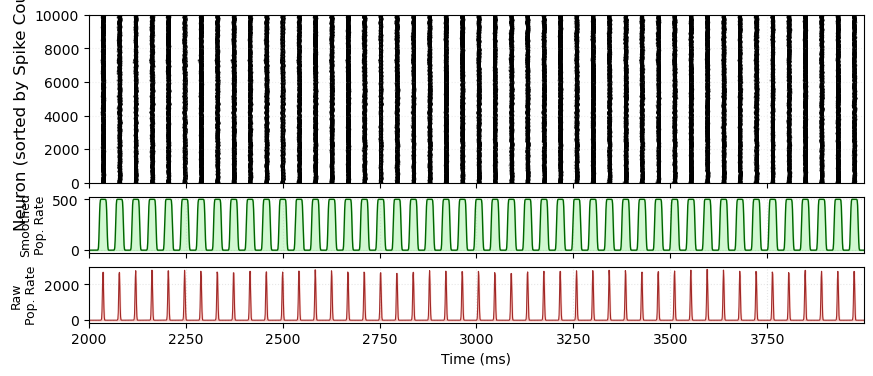

✅ Données sauvegardées dans raster_data_t0100/


C:\Users\User\AppData\Local\Temp\ipykernel_21052\15237210.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


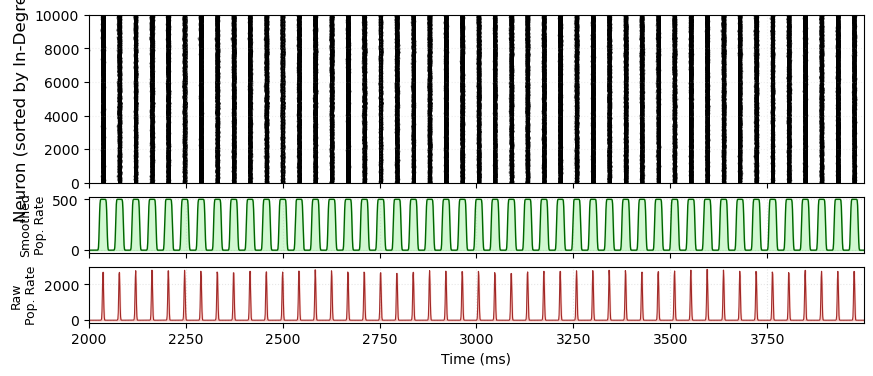

✅ Données sauvegardées dans raster_data_t0200/


C:\Users\User\AppData\Local\Temp\ipykernel_21052\15237210.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


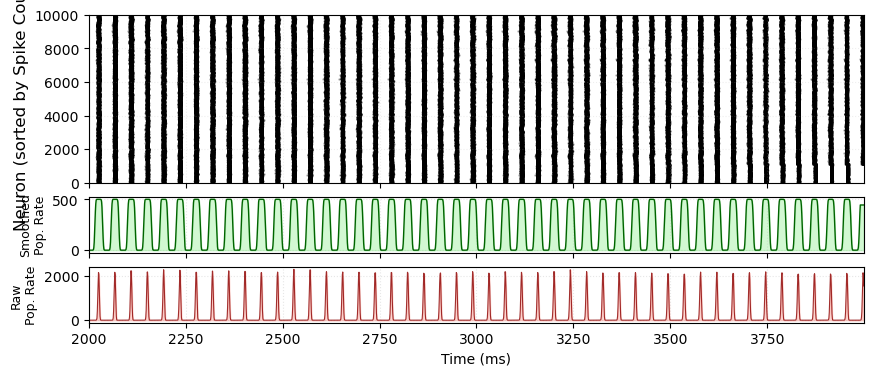

✅ Données sauvegardées dans raster_data_t0200/


C:\Users\User\AppData\Local\Temp\ipykernel_21052\15237210.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


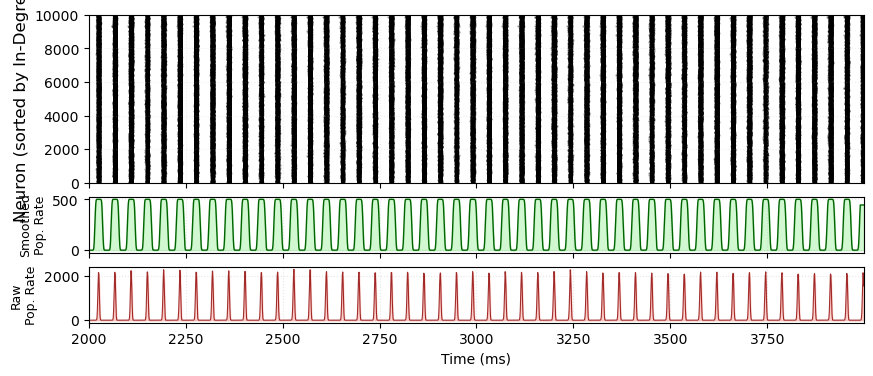

✅ Données sauvegardées dans raster_data_t0260/


C:\Users\User\AppData\Local\Temp\ipykernel_21052\15237210.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


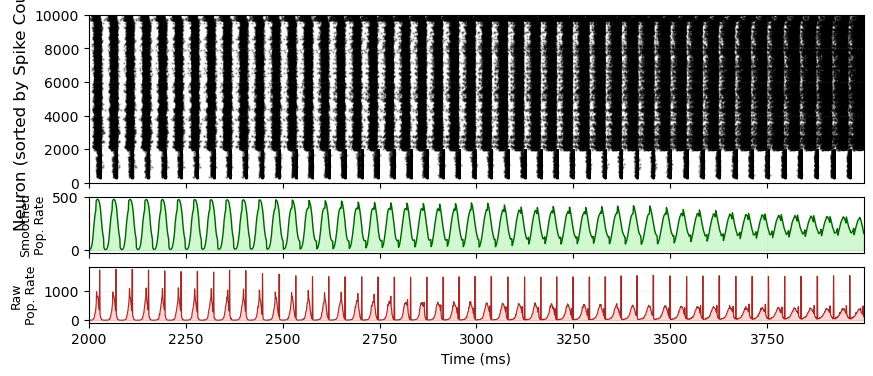

✅ Données sauvegardées dans raster_data_t0260/


C:\Users\User\AppData\Local\Temp\ipykernel_21052\15237210.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


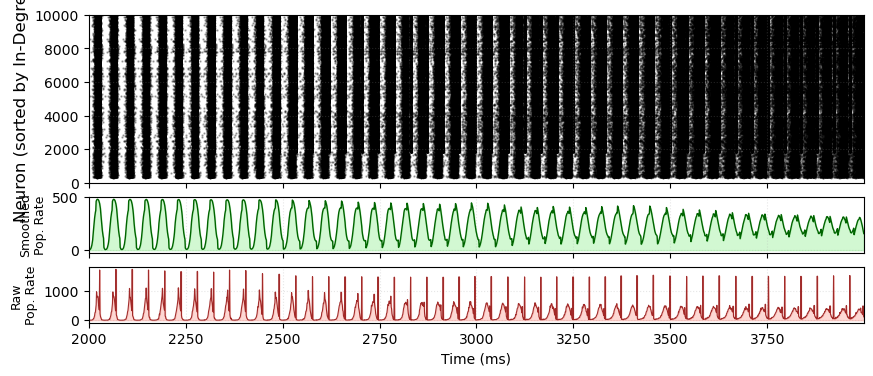

✅ Données sauvegardées dans raster_data_t0275/


C:\Users\User\AppData\Local\Temp\ipykernel_21052\15237210.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


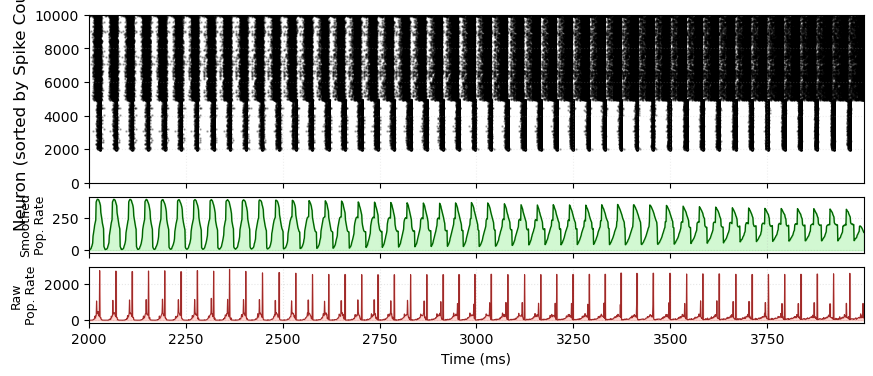

✅ Données sauvegardées dans raster_data_t0275/


C:\Users\User\AppData\Local\Temp\ipykernel_21052\15237210.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


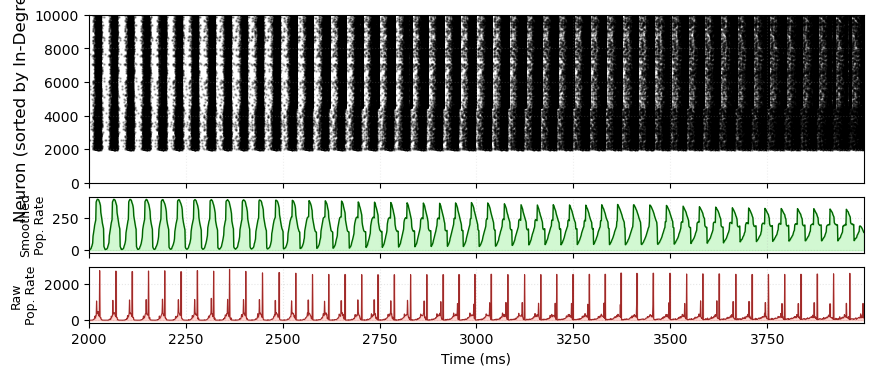

✅ Données sauvegardées dans raster_data_t0300/


C:\Users\User\AppData\Local\Temp\ipykernel_21052\15237210.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


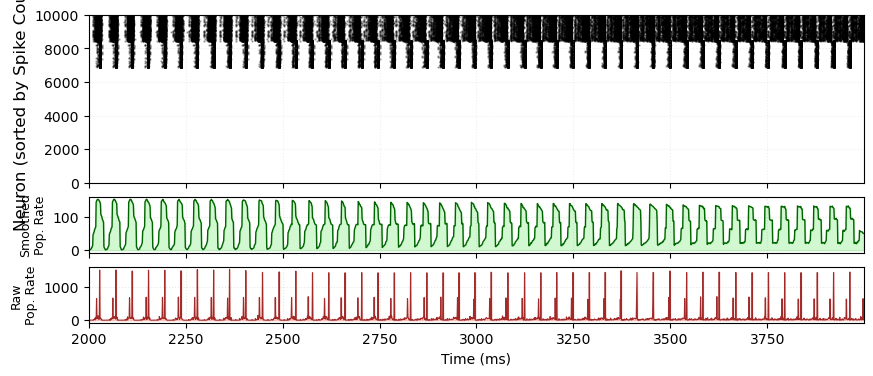

✅ Données sauvegardées dans raster_data_t0300/


C:\Users\User\AppData\Local\Temp\ipykernel_21052\15237210.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


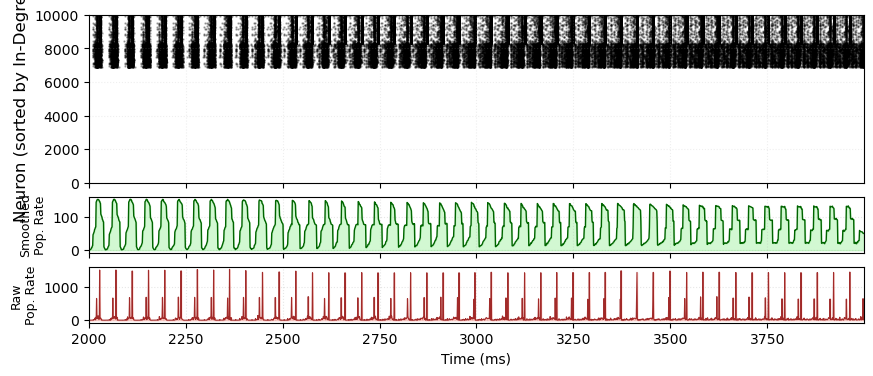

✅ Données sauvegardées dans raster_data_t0350/


C:\Users\User\AppData\Local\Temp\ipykernel_21052\15237210.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


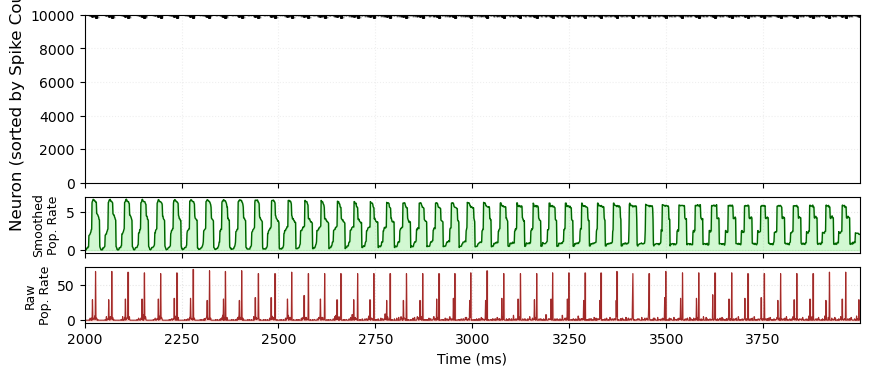

✅ Données sauvegardées dans raster_data_t0350/


C:\Users\User\AppData\Local\Temp\ipykernel_21052\15237210.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


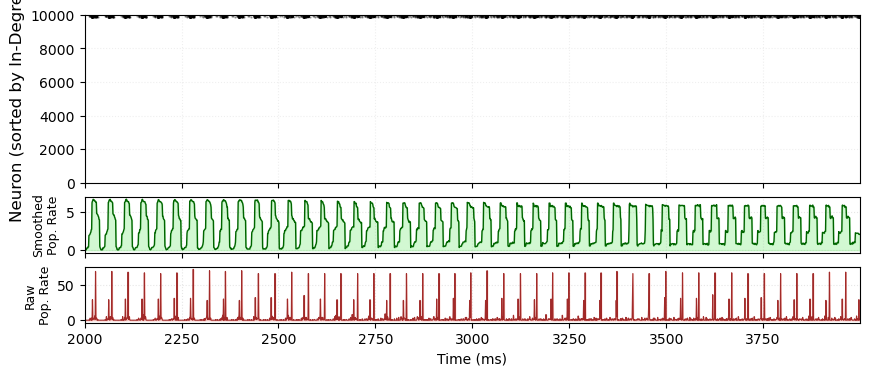

In [4]:
for t in [100, 200, 260, 275, 300, 350]:
    plot_sorted_raster(t, sort_by='spike_count', show_last_fraction=0.5, save_data=True)
    plot_sorted_raster(t, sort_by='in_degree', show_last_fraction=0.5, save_data=True)